### Here we start by cahnging from hourly data into daily data for the SOMC_AC_3600, we are going to make an average daily comsumption for the model to match with the daily 

In [15]:
import pandas as pd

# === 1. Cargar el archivo CSV ===
file_path = "SOMC_AC_20240505_20250505_3600.csv"
df = pd.read_csv(file_path)

# === 2. Eliminar la columna 'toll_booth' si existe ===
if 'toll_booth' in df.columns:
    df = df.drop(columns=['toll_booth'])

# === 3. Convertir 'data_time' a tipo datetime y extraer solo la fecha
df['data_time'] = pd.to_datetime(df['data_time'])
df['date'] = df['data_time'].dt.date

# === 4. Normalizar el gantry eliminando "-" y "."
df['gantry_norm'] = df['gantry'].astype(str).str.replace("-", "", regex=False).str.replace(".", "", regex=False)

# === 5. Agrupar por gantry normalizado y fecha, calculando el promedio diario
daily_df = df.groupby(['gantry_norm', 'date']).mean(numeric_only=True).reset_index()

# === 6. Guardar la salida como nuevo CSV
daily_df.to_csv("daily_weather_by_gantry_cleaned.csv", index=False)
print("✅ Archivo generado con gantry limpio como 'daily_weather_by_gantry_cleaned.csv'")


✅ Archivo generado con gantry limpio como 'daily_weather_by_gantry_cleaned.csv'


### This is where preprocessing happens, we are going to normalize the columns, match gantries that exist and also unify them into just one csv, here we use the Daily_weather_By_Gantry_Cleanned.CSV with the Electricity data of the toll station-phase, we normalize Location ID deleting ". and -" and just much based on this with the 2 documents

In [16]:
import pandas as pd

# === 1. Cargar archivo diario con gantry normalizado ===
daily = pd.read_csv("daily_weather_by_gantry_cleaned.csv")

# === 2. Cargar archivo de metadata (segunda fila como header) ===
infra = pd.read_excel("Electricity data of the toll station-phase 1.xlsx", header=1)

# === 3. Limpiar gantries en metadata ===
infra = infra[infra['Location ID'].notna()]
infra['gantry_norm'] = (
    infra['Location ID'].astype(str)
    .str.replace("-", "", regex=False)
    .str.replace(".", "", regex=False)
)

# === 4. Seleccionar columnas útiles de la metadata ===
infra = infra[['gantry_norm', 'Latitude', 'Longitude', 'Equipment Lane Count', 'Lane Count']]

# === 5. Hacer merge (intersección) con el dataset diario ===
merged = pd.merge(daily, infra, on='gantry_norm', how='inner')

# === 6. Guardar CSV combinado ===
merged.to_csv("daily_weather_with_metadata.csv", index=False)
print("✅ Archivo combinado guardado como 'daily_weather_with_metadata.csv'")


✅ Archivo combinado guardado como 'daily_weather_with_metadata.csv'


### For this part We unify the temperature by station so that we can match the data in the future, I did this for the 19 stations because the format of the csv was difficult to read, so manually add the latitude, longitude and name inside the code and this allows to fill the columns automatically
### How did I compute this?: I open each csv, copy the name of the document, copy latitude, longitude, for each document, the reason i did it this way is because i was having problem recognizing the characters and the columns

In [42]:
import pandas as pd

file_path = "Meteorological data/逐日平均氣溫年報表_2024 麟洛 _ csv_14.csv"
year = 2024

# Leer desde la fila 6 (saltando metadatos)
df = pd.read_csv(file_path, skiprows=5, header=0, encoding='utf-8-sig')

# Renombrar columnas
df = df.iloc[:, :-1]  # eliminar columna duplicada final
df.columns = ['Day'] + list(range(1, 13))  # meses 1 al 12

# Convertir a formato largo
melted = df.melt(id_vars='Day', var_name='Month', value_name='temperature')
melted.dropna(subset=['temperature'], inplace=True)

# Filtrar días válidos
melted = melted[pd.to_numeric(melted['Day'], errors='coerce').notnull()]
melted['Day'] = melted['Day'].astype(int)
melted['Month'] = melted['Month'].astype(int)

# Crear columna de fecha M/D/YYYY
melted['date'] = melted.apply(lambda row: f"{row['Month']}/{row['Day']}/{year}", axis=1)

# Agregar metadatos
melted['StationName'] = "LINLUO"
melted['StationID'] = "C0R570"
melted['Latitude'] = 22.65256
melted['Longitude'] = 120.51914

# Selección final
result = melted[['date', 'temperature', 'StationName', 'StationID', 'Latitude', 'Longitude']]
print(result.head())

# Guardar CSV
result.to_csv("temperature_LINLUO_C0R570.csv", index=False)
print("✅ Archivo guardado como 'temperature_LINLUO_C0R570.csv'")


       date temperature StationName StationID  Latitude  Longitude
0  1/1/2024        21.8      LINLUO    C0R570  22.65256  120.51914
1  1/2/2024        21.4      LINLUO    C0R570  22.65256  120.51914
2  1/3/2024        20.3      LINLUO    C0R570  22.65256  120.51914
3  1/4/2024        18.9      LINLUO    C0R570  22.65256  120.51914
4  1/5/2024        20.0      LINLUO    C0R570  22.65256  120.51914
✅ Archivo guardado como 'temperature_LINLUO_C0R570.csv'


### Here I unify all the separated temperatures, only one big csv having all the temperatures, all temperatures by station, longitud and latitude.

In [5]:
import pandas as pd
import os

folder = "TemperatureByDate"
all_data = []

for file in os.listdir(folder):
    if file.endswith(".csv"):
        file_path = os.path.join(folder, file)
        print(f"🔄 Cargando {file}")
        try:
            df = pd.read_csv(file_path)

            # 🧼 Standardize column names and order
            df.columns = [col.strip().lower() for col in df.columns]

            expected_columns = ['date', 'temperature', 'stationname', 'stationid', 'latitude', 'longitude']

            # Try to reorder if possible
            if set(df.columns) >= set(expected_columns):
                df = df[expected_columns]
            else:
                print(f"⚠️ Column mismatch in {file}, skipping")
                continue

            # ✅ Auto-fix swapped lat/lon if needed
            df['latitude'] = df.apply(lambda row: float(row['latitude']) if float(row['latitude']) < 40 else float(row['longitude']), axis=1)
            df['longitude'] = df.apply(lambda row: float(row['longitude']) if float(row['longitude']) > 100 else float(row['latitude']), axis=1)

            all_data.append(df)

        except Exception as e:
            print(f"❌ Error al leer {file}: {e}")

# Combinar y guardar
if not all_data:
    print("❌ No se encontraron archivos válidos.")
else:
    unified = pd.concat(all_data, ignore_index=True)
    unified.drop_duplicates(inplace=True)
    unified.sort_values(by=["stationid", "date"], inplace=True)
    unified.to_csv("unified_temperature.csv", index=False)
    print("✅ Archivo guardado como 'unified_temperature.csv'")


🔄 Cargando temperature_BANCHIAO_C0AJ80.csv
🔄 Cargando temperature_CHIAYI_467480.csv
🔄 Cargando temperature_DONGQU_HSINCHU_C0D660.csv
🔄 Cargando temperature_DOUNAN_C0K460.csv
🔄 Cargando temperature_HENGCHUN_467590.csv
🔄 Cargando temperature_KAOHSIUNG_467441.csv
🔄 Cargando temperature_KEELUNG_466940.csv
🔄 Cargando temperature_LINLUO_C0R570.csv
🔄 Cargando temperature_MIAOLI_C0E750.csv
🔄 Cargando temperature_NANTOU_C0I460.csv
🔄 Cargando temperature_SHENKENG_C0AH80.csv
🔄 Cargando temperature_SUAO_C0UB10.csv
🔄 Cargando temperature_TAICHUNG_467490.csv
🔄 Cargando temperature_TAINAN_467410.csv
🔄 Cargando temperature_TAIPEI_466920.csv
🔄 Cargando temperature_TAOYUAN_C0C480.csv
🔄 Cargando temperature_Wugu_C0AI00.csv
🔄 Cargando temperature_YILAN_467080.csv
🔄 Cargando temperature_YUANLIN_C0G650.csv
✅ Archivo guardado como 'unified_temperature.csv'


### Just extra for confirmation to see if the latitudes and logitude coincide with the CSV provided as Meteorological Station List, no need execution for this part, this code only gives me a new xlsx to see if the names macth with the latitude and logitude, 3 of them did not but confirmed manually and indeed coincides correctly. 


In [14]:
import pandas as pd
import re

# === Function to convert DMS to decimal ===
def dms_to_decimal(dms):
    dms = dms.replace("′", "'").replace("″", "").replace("’", "'").strip()
    match = re.match(r"(\d+)°(\d+)'([\d.]+)\"?([NSEW])", dms)
    if not match:
        return None
    deg, mins, secs, direction = match.groups()
    decimal = int(deg) + int(mins) / 60 + float(secs) / 3600
    if direction in ['S', 'W']:
        decimal *= -1
    return round(decimal, 5)

# === Load station list (Excel)
ref = pd.read_excel("Meteorological Station List.xlsx", sheet_name=0, header=2)

# === Extract StationName and StationID
ref[['StationName', 'StationID']] = ref['Meteorological Station'].str.extract(r'([A-Za-z\s]+)\s+([A-Z0-9]+)')
ref['StationName'] = ref['StationName'].str.strip().str.upper()
ref['StationID'] = ref['StationID'].str.strip()

# === Split and convert lat/lon
ref[['LatitudeDMS', 'LongitudeDMS']] = ref['LatitudeLongitude'].str.extract(r'(.+?)\s+(.+)')
ref['latitude'] = ref['LatitudeDMS'].apply(dms_to_decimal)
ref['longitude'] = ref['LongitudeDMS'].apply(dms_to_decimal)
ref['latitude'] = ref['latitude'].round(5)
ref['longitude'] = ref['longitude'].round(5)

# === Load unified_temperature
unified = pd.read_csv("unified_temperature.csv")
unified['stationname'] = unified['stationname'].str.upper()
unified['latitude'] = unified['latitude'].round(5)
unified['longitude'] = unified['longitude'].round(5)

# === Group by coordinates in unified data
lookup = unified.groupby(['latitude', 'longitude'])[['stationname', 'stationid']].first().reset_index()

# === Merge by coordinates
ref_merged = ref.merge(lookup, on=['latitude', 'longitude'], how='left')

# === Compare station info
ref_merged['MatchStatus'] = ref_merged.apply(
    lambda row: '✅ MATCH' if row['StationName'] == row['stationname'] and str(row['StationID']) == str(row['stationid'])
    else '❌ MISMATCH',
    axis=1
)

# === Save result
ref_merged.to_excel("Meteorological Station List VERIFIED.xlsx", index=False)
print("✅ Saved as 'Meteorological Station List VERIFIED.xlsx'")


✅ Saved as 'Meteorological Station List VERIFIED.xlsx'


### Now it is time to have one unique csv with all the temperatures and matches per day.
### Once having the gantries per date, location, etc and having the temperatures by date and station, the idea is to use 

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# === Step 1: Load and clean data ===
main_df = pd.read_csv("daily_weather_with_metadata.csv")
station_df = pd.read_csv("unified_temperature.csv")

# Normalize column names
main_df.columns = [col.strip().lower() for col in main_df.columns]
station_df.columns = [col.strip().lower() for col in station_df.columns]

# Parse dates to datetime
main_df['date'] = pd.to_datetime(main_df['date'], errors='coerce')
station_df['date'] = pd.to_datetime(station_df['date'], errors='coerce')

# Remove invalid temperature values
invalid_vals = ['/', 'x', 'X']
station_df = station_df[~station_df['temperature'].isin(invalid_vals)]
station_df = station_df.dropna(subset=['temperature', 'latitude', 'longitude'])

# Group stations by date for fast filtering
station_by_date = {
    date: group.reset_index(drop=True)
    for date, group in station_df.groupby('date')
}

# === Step 2: Match station and calculate energy consumption ===
final_rows = []

for date in main_df['date'].dropna().unique():
    daily_main = main_df[main_df['date'] == date].copy().reset_index(drop=True)
    daily_stations = station_by_date.get(date, pd.DataFrame())

    if daily_stations.empty:
        for _, row in daily_main.iterrows():
            final_rows.append(row.to_dict() | {
                "stationid": None,
                "stationname": None,
                "station_latitude": None,
                "station_longitude": None,
                "temperature": None,
                "distance_km": None,
                "avg_ac_voltage": None,
                "ac_power_watts": None,
                "dc_power_watts": None,
                "total_energy_watts": None
            })
        continue

    # Convert coordinates to radians
    station_coords_rad = np.radians(daily_stations[['latitude', 'longitude']].values)
    tree = BallTree(station_coords_rad, metric='haversine')

    # Convert target points to radians
    target_coords_rad = np.radians(daily_main[['latitude', 'longitude']].values)
    dist, idx = tree.query(target_coords_rad, k=1)

    for i in range(len(daily_main)):
        row = daily_main.iloc[i]
        nearest = daily_stations.iloc[idx[i][0]]
        distance_km = dist[i][0] * 6371  # Earth radius

        # === Energy calculations ===
        try:
            ac_a = row['ac_a_current']
            ac_b = row['ac_b_current']
            smr_i = row['smr_dc_current']
            smr_v = row['smr_dc_voltage']
            l1_v = row['mains_power_l1_voltage']
            l2_v = row['mains_power_l2_voltage']
            mains_current = row['mains_power_220_current']

            avg_voltage = (l1_v + l2_v) / 2
            ac_power_watts = (ac_a + ac_b) * avg_voltage
            dc_power_watts = smr_i * smr_v
            total_energy_watts = mains_current * avg_voltage
        except:
            avg_voltage = None
            ac_power_watts = None
            dc_power_watts = None
            total_energy_watts = None

        final_rows.append(row.to_dict() | {
            "stationid": nearest['stationid'],
            "stationname": nearest['stationname'],
            "station_latitude": nearest['latitude'],
            "station_longitude": nearest['longitude'],
            "temperature": nearest['temperature'],
            "distance_km": round(distance_km, 3),
            "avg_ac_voltage": avg_voltage,
            "ac_power_watts": ac_power_watts,
            "dc_power_watts": dc_power_watts,
            "total_energy_watts": total_energy_watts
        })

# === Step 3: Save final CSV ===
final_df = pd.DataFrame(final_rows)
final_df.to_csv("training_ready_dataset_balltree.csv", index=False)
print("✅ Archivo generado con cálculos energéticos incluidos.")


✅ Archivo generado con cálculos energéticos incluidos.


In [3]:
import pandas as pd
import folium

# === 1. Cargar el archivo CSV ===
df = pd.read_csv("training_ready_dataset_balltree.csv")

# === 2. Filtrar solo filas con temperatura y coordenadas válidas ===
df = df.dropna(subset=['temperature', 'station_latitude', 'station_longitude'])

# === 3. Crear el mapa centrado en Taiwán ===
m = folium.Map(location=[23.7, 121.0], zoom_start=7)

# === 4. Agregar estaciones meteorológicas ===
station_group = folium.FeatureGroup(name="Weather Stations")
stations = df[['stationid', 'stationname', 'station_latitude', 'station_longitude']].drop_duplicates()
for _, row in stations.iterrows():
    folium.Marker(
        location=[row['station_latitude'], row['station_longitude']],
        popup=f"Station: {row['stationname']}",
        icon=folium.Icon(color='blue', icon='cloud')
    ).add_to(station_group)
station_group.add_to(m)

# === 5. Agregar pórticos (gantries) con líneas ===
gantry_group = folium.FeatureGroup(name="Gantries with Temperature")
for _, row in df.iterrows():
    # Punto del pórtico
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Gantry: {row['gantry_norm']}<br>Distance: {row['distance_km']} km<br>Temp: {row['temperature']}°C",
        icon=folium.Icon(color='green', icon='road')
    ).add_to(gantry_group)

    # Línea hasta la estación asociada
    folium.PolyLine(
        locations=[
            [row['latitude'], row['longitude']],
            [row['station_latitude'], row['station_longitude']]
        ],
        color='gray',
        weight=1,
        opacity=0.5
    ).add_to(m)
gantry_group.add_to(m)

# === 6. Controles y exportación ===
folium.LayerControl().add_to(m)
m.save("mapa_gantries_estaciones.html")
print("✅ Mapa guardado como 'mapa_gantries_estaciones.html'")


C:\Users\gusta\AppData\Local\Temp\ipykernel_18748\3993434029.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


✅ Mapa guardado como 'mapa_gantries_estaciones.html'


C:\Users\gusta\AppData\Local\Temp\ipykernel_18748\1996239094.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")
C:\Users\gusta\AppData\Local\Temp\ipykernel_18748\1996239094.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\gusta\AppData\Local\Temp\ipykernel_18748\1996239094.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("taiwan_gantry_station_plot.png", dpi=300)
c:\Users\gusta\.conda\envs\MachineLearning\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


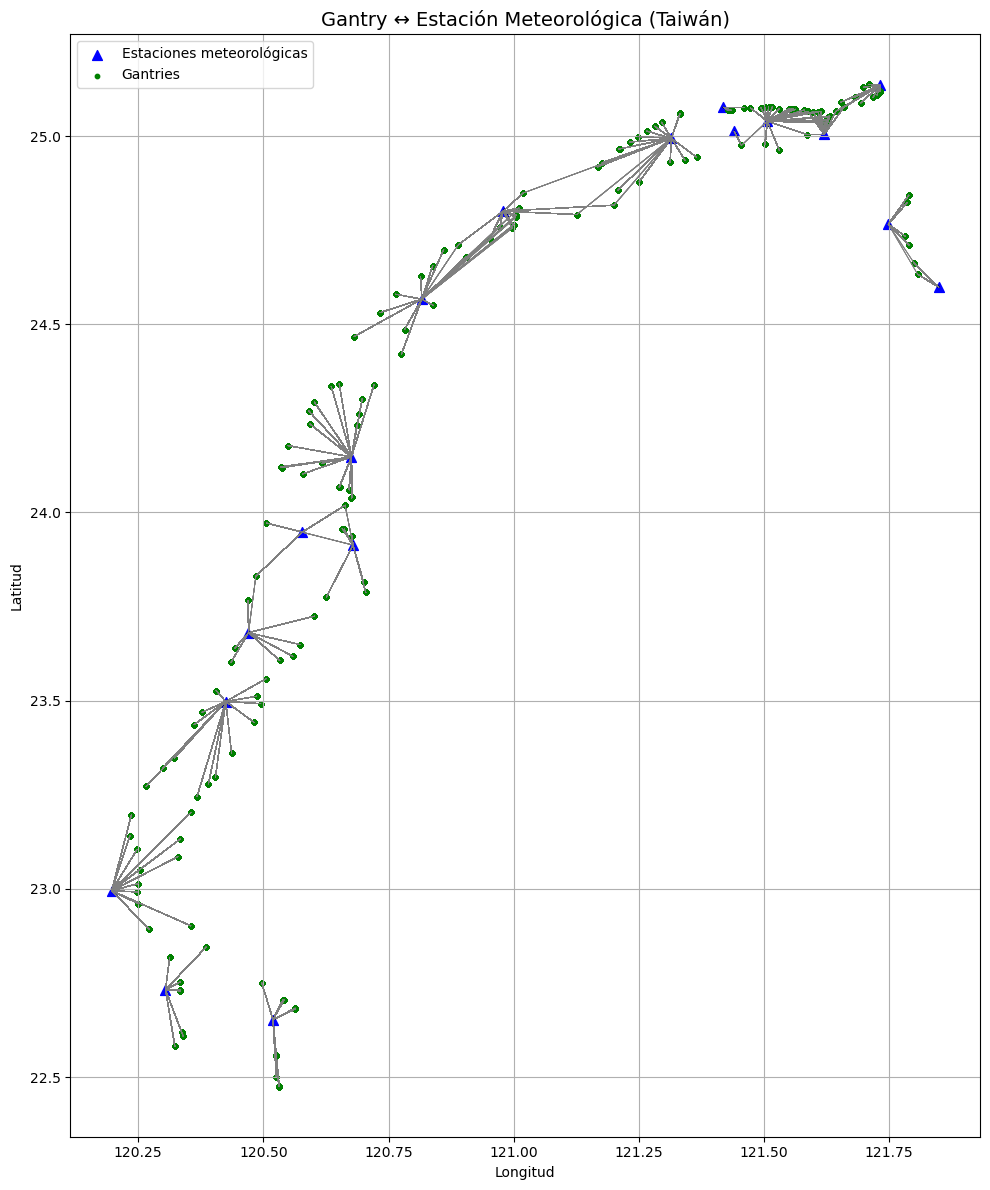

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo
df = pd.read_csv("training_ready_dataset_balltree.csv")

# Filtrar solo los que tienen temperatura válida y coordenadas
df = df.dropna(subset=['temperature', 'station_latitude', 'station_longitude'])

# Crear figura
plt.figure(figsize=(10, 12))
plt.title("Gantry ↔ Estación Meteorológica (Taiwán)", fontsize=14)

# Dibujar líneas entre gantry y estación
for _, row in df.iterrows():
    plt.plot(
        [row['longitude'], row['station_longitude']],
        [row['latitude'], row['station_latitude']],
        color='gray', linewidth=0.5, alpha=0.5
    )

# Dibujar estaciones (azul)
stations = df[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
plt.scatter(
    stations['station_longitude'], stations['station_latitude'],
    color='blue', label='Estaciones meteorológicas', s=50, marker='^'
)

# Dibujar gantries (verde)
plt.scatter(
    df['longitude'], df['latitude'],
    color='green', label='Gantries', s=10
)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("taiwan_gantry_station_plot.png", dpi=300)
plt.show()


### Modelo de prueba 

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === 1. Cargar y limpiar ===
df = pd.read_csv("training_ready_dataset_balltree.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].dt.year == 2024]

# Remover filas incompletas en columnas clave
key_cols = [
    'temperature', 'lane count', 'equipment lane count', 'rs485_temperature',
    'ac_a_current', 'ac_b_current', 'mains_power_220_current',
    'mains_power_l1_voltage', 'mains_power_l2_voltage',
    'smr_dc_current', 'smr_dc_voltage', 'total_energy_watts'
]
df = df.dropna(subset=key_cols)

# === 2. Feature engineering ===
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['equipment_lane_ratio'] = df['equipment lane count'] / df['lane count'].replace(0, np.nan)

# === 3. Quitar outliers (1% y 99%) ===
low, high = df['total_energy_watts'].quantile([0.01, 0.99])
df = df[(df['total_energy_watts'] >= low) & (df['total_energy_watts'] <= high)]

# === 4. Features y target ===
features = [
    'temperature', 'rs485_temperature', 'lane count', 'equipment lane count',
    'equipment_lane_ratio', 'ac_a_current', 'ac_b_current',
    'mains_power_220_current', 'mains_power_l1_voltage', 'mains_power_l2_voltage',
    'smr_dc_current', 'smr_dc_voltage', 'month', 'dayofweek'
]
target = 'total_energy_watts'

X = df[features]
y = df[target]

# === 5. Modelo ===
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=0
)

# === 6. Cross-validation ===
pool = Pool(X, y)
cv_result = cv(pool, model.get_params(), fold_count=5, shuffle=True, partition_random_seed=42, verbose=False)

print("📊 Cross-validation RMSE:", round(cv_result['test-RMSE-mean'].iloc[-1], 2))

# === 7. Train/test holdout ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 8. Evaluación final ===
print("\n✅ Evaluación en hold-out:")
print("R² Score:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2), "watts")
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2), "watts")


C:\Users\gusta\AppData\Local\Temp\ipykernel_23412\3234731533.py:8: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


Training on fold [0/5]

bestTest = 5.16906727
bestIteration = 499

Training on fold [1/5]

bestTest = 5.215016435
bestIteration = 499

Training on fold [2/5]

bestTest = 5.407130473
bestIteration = 499

Training on fold [3/5]

bestTest = 5.434774015
bestIteration = 499

Training on fold [4/5]

bestTest = 5.288231622
bestIteration = 499

📊 Cross-validation RMSE: 5.3

✅ Evaluación en hold-out:
R² Score: 1.0
MAE: 3.02 watts
RMSE: 4.65 watts


In [12]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Cargar CSV
df = pd.read_csv("training_ready_dataset_balltree.csv")

# 2. Variables relevantes
features = ['temperature', 'lane count']
target = 'total_energy_watts'

# 3. Eliminar nulos
df_model = df[features + [target]].dropna()
print(f"✅ Filas válidas: {len(df_model)}")

if len(df_model) == 0:
    raise ValueError("❌ No hay datos suficientes para entrenar.")

# 4. División de datos
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Modelo
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)

# 6. Evaluación
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 RMSE del modelo: {rmse:.2f}")


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2220649923.py:8: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


✅ Filas válidas: 146162
📊 RMSE del modelo: 10543.08


In [16]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 1. Load and Prepare Data ===
df = pd.read_csv("cleaned_energy_dataset_with_interaction.csv")

# Use only the relevant columns
df = df[['temperature', 'lane count', 'total_energy_watts']].dropna()

# Features and target
X = df[['temperature', 'lane count']]
y = df['total_energy_watts']

# === 2. Split Data (80% train, 20% test) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Train CatBoost Model ===
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)

# === 4. Predict and Evaluate ===
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE manually computed
mae = mean_absolute_error(y_test, y_pred)

print(f"🔍 Model Evaluation Metrics:")
print(f" - R² Score: {r2:.4f}")
print(f" - RMSE: {rmse:.2f} watts")
print(f" - MAE: {mae:.2f} watts")

# === 5. Predict Average Energy from Temperature Range and Lane Count ===
def predict_energy_for_range(temp_min, temp_max, lane_count):
    temp_range = np.linspace(temp_min, temp_max, num=50)
    input_data = pd.DataFrame({
        'temperature': temp_range,
        'lane count': [lane_count] * len(temp_range)
    })
    predictions = model.predict(input_data)
    return predictions.mean()

# === 6. Example Usage ===
avg_energy = predict_energy_for_range(20, 25, 3)
print(f"\n⚡ Predicted average energy for 20–25°C and 3 lanes: {avg_energy:.2f} watts")


🔍 Model Evaluation Metrics:
 - R² Score: 0.2883
 - RMSE: 181.58 watts
 - MAE: 148.80 watts

⚡ Predicted average energy for 20–25°C and 3 lanes: 1083.68 watts


In [15]:
import pandas as pd

# === 1. Cargar datos y filtrar valores nulos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'total_energy_watts']].dropna()

# === 2. Eliminar outliers con IQR ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1

# Mantener solo valores dentro de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
filtered_df = df[(df['total_energy_watts'] >= Q1 - 1.5 * IQR) &
                 (df['total_energy_watts'] <= Q3 + 1.5 * IQR)]

print(f"✅ Filas antes: {len(df)}, después de eliminar outliers: {len(filtered_df)}")

# === 3. Agregar variable de interacción ===
filtered_df['temp_lane_interaction'] = filtered_df['temperature'] * filtered_df['lane count']

# Guardar el dataset limpio y expandido
filtered_df.to_csv("cleaned_energy_dataset_with_interaction.csv", index=False)
print("✅ Dataset guardado como cleaned_energy_dataset_with_interaction.csv")


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1275639312.py:4: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")
C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1275639312.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['temp_lane_interaction'] = filtered_df['temperature'] * filtered_df['lane count']


✅ Filas antes: 146162, después de eliminar outliers: 139207
✅ Dataset guardado como cleaned_energy_dataset_with_interaction.csv


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\711263102.py:7: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


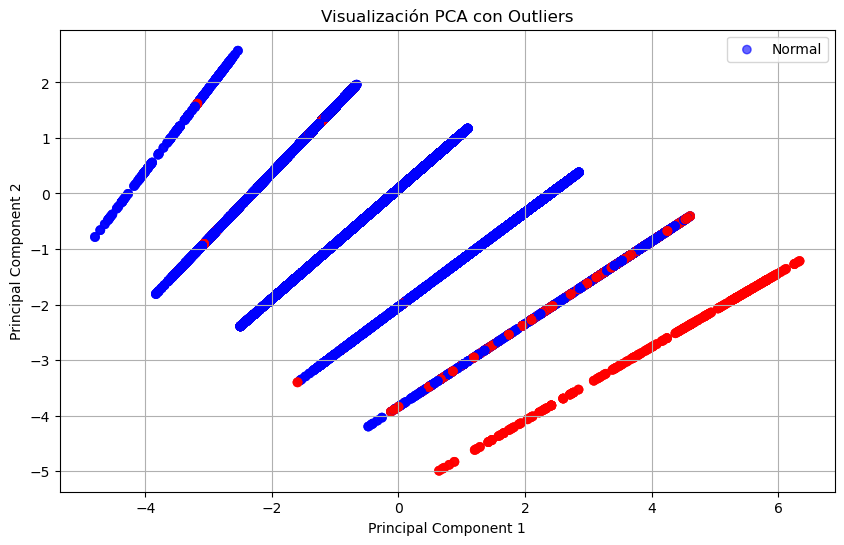

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# === 1. Cargar el dataset (debe contener 'temperature', 'lane count', 'total_energy_watts') ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'total_energy_watts']].dropna()

# === 2. Detectar outliers usando IQR ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['is_outlier'] = (df['total_energy_watts'] < lower) | (df['total_energy_watts'] > upper)

# === 3. Crear variable de interacción (opcional) ===
df['temp_lane_interaction'] = df['temperature'] * df['lane count']

# === 4. Aplicar StandardScaler + PCA (2 componentes) ===
features = ['temperature', 'lane count', 'temp_lane_interaction']
X = StandardScaler().fit_transform(df[features])
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df['PC1'] = components[:, 0]
df['PC2'] = components[:, 1]

# === 5. Graficar ===
plt.figure(figsize=(10, 6))
plt.scatter(df['PC1'], df['PC2'], c=df['is_outlier'].map({True: 'red', False: 'blue'}),
            alpha=0.6, label='Datos')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Visualización PCA con Outliers')
plt.legend(['Normal', 'Outlier'])
plt.grid(True)
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\3710761528.py:7: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


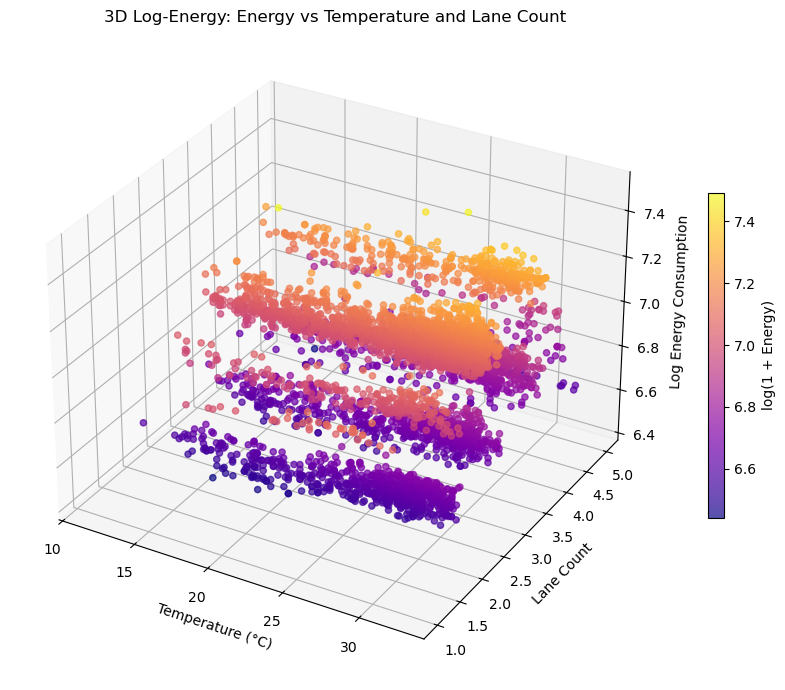

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 1. Cargar dataset y eliminar nulos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'total_energy_watts']].dropna()

# === 2. Eliminar outliers usando IQR ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Tomar muestra aleatoria para evitar errores de memoria ===
df_sample = df_clean.sample(n=5000, random_state=42)

# === 4. Aplicar logaritmo en energía (agregar columna log_energy) ===
df_sample['log_energy'] = np.log1p(df_sample['total_energy_watts'])  # log1p evita log(0)

# === 5. Gráfico 3D con log_energy ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    df_sample['temperature'],
    df_sample['lane count'],
    df_sample['log_energy'],
    c=df_sample['log_energy'],
    cmap='plasma',
    alpha=0.7
)

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Lane Count")
ax.set_zlabel("Log Energy Consumption")
ax.set_title("3D Log-Energy: Energy vs Temperature and Lane Count")

plt.colorbar(sc, ax=ax, shrink=0.5, label='log(1 + Energy)')
plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\4240142839.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


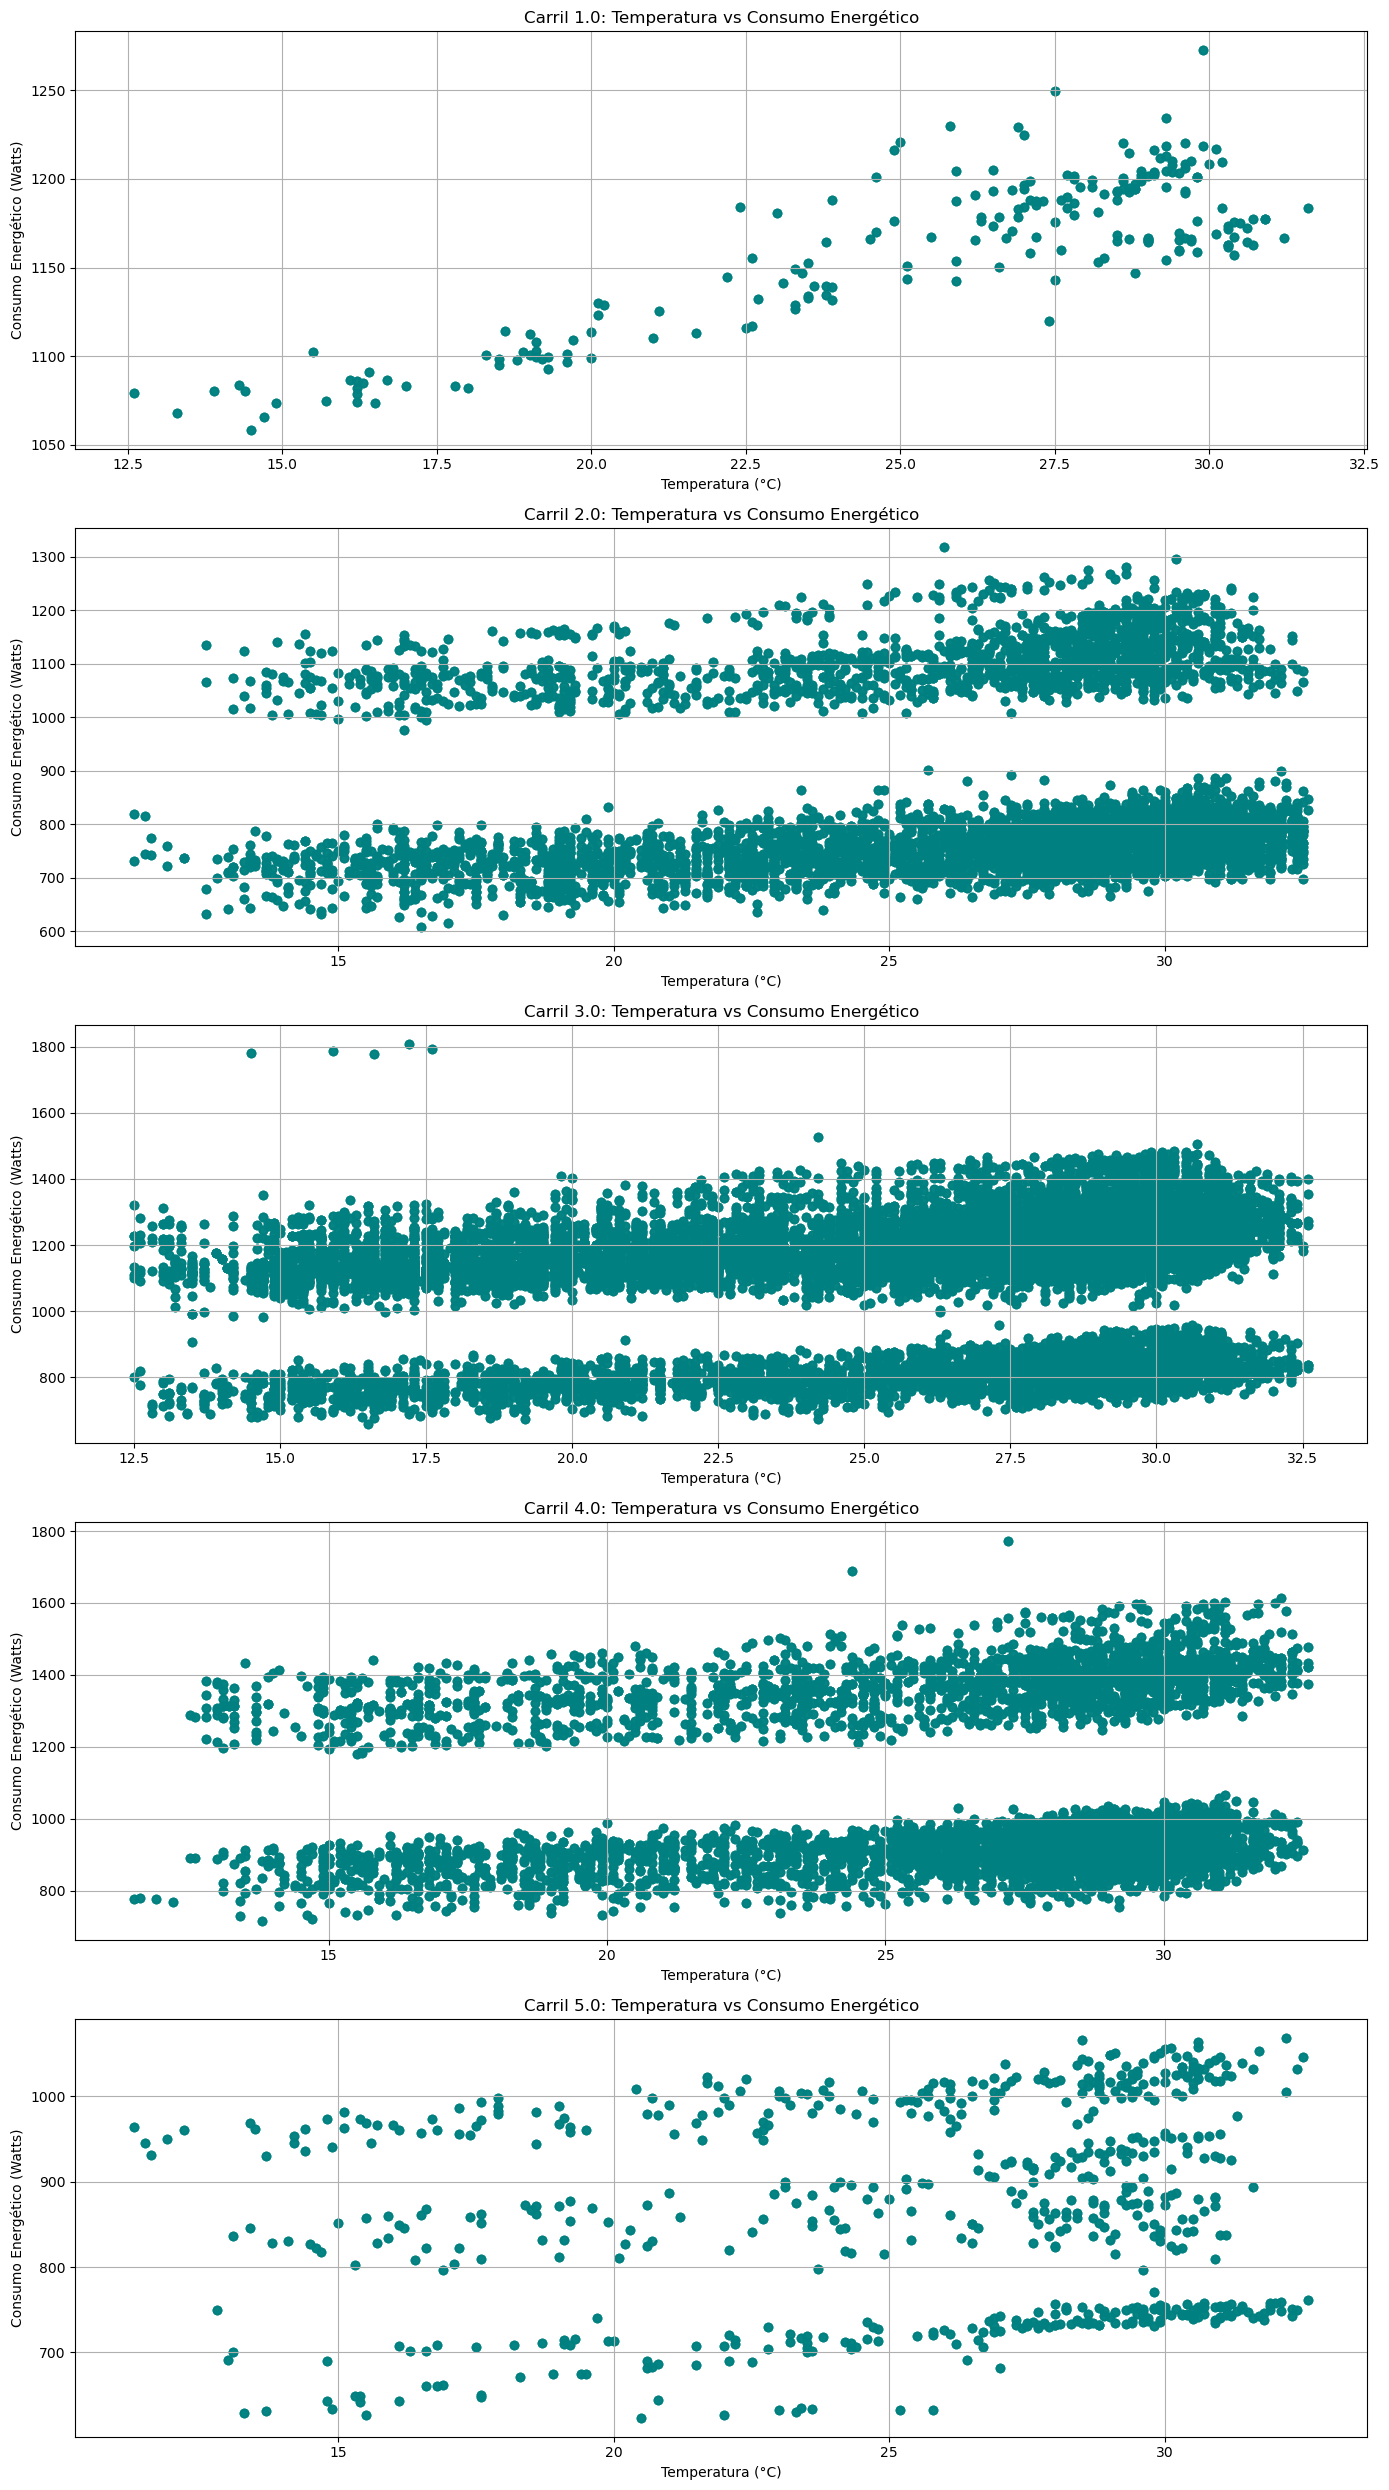

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar y preparar dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'total_energy_watts']].dropna()

# === 2. Eliminar outliers (IQR en total_energy_watts) ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Graficar temperatura vs energía para cada lane ===
unique_lanes = sorted(df_clean['lane count'].unique())

plt.figure(figsize=(14, 5 * len(unique_lanes)))

for i, lane in enumerate(unique_lanes, 1):
    df_lane = df_clean[df_clean['lane count'] == lane]
    plt.subplot(len(unique_lanes), 1, i)
    plt.scatter(df_lane['temperature'], df_lane['total_energy_watts'], alpha=0.6, color='teal')
    plt.title(f"Carril {lane}: Temperatura vs Consumo Energético")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Consumo Energético (Watts)")
    plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2367901349.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


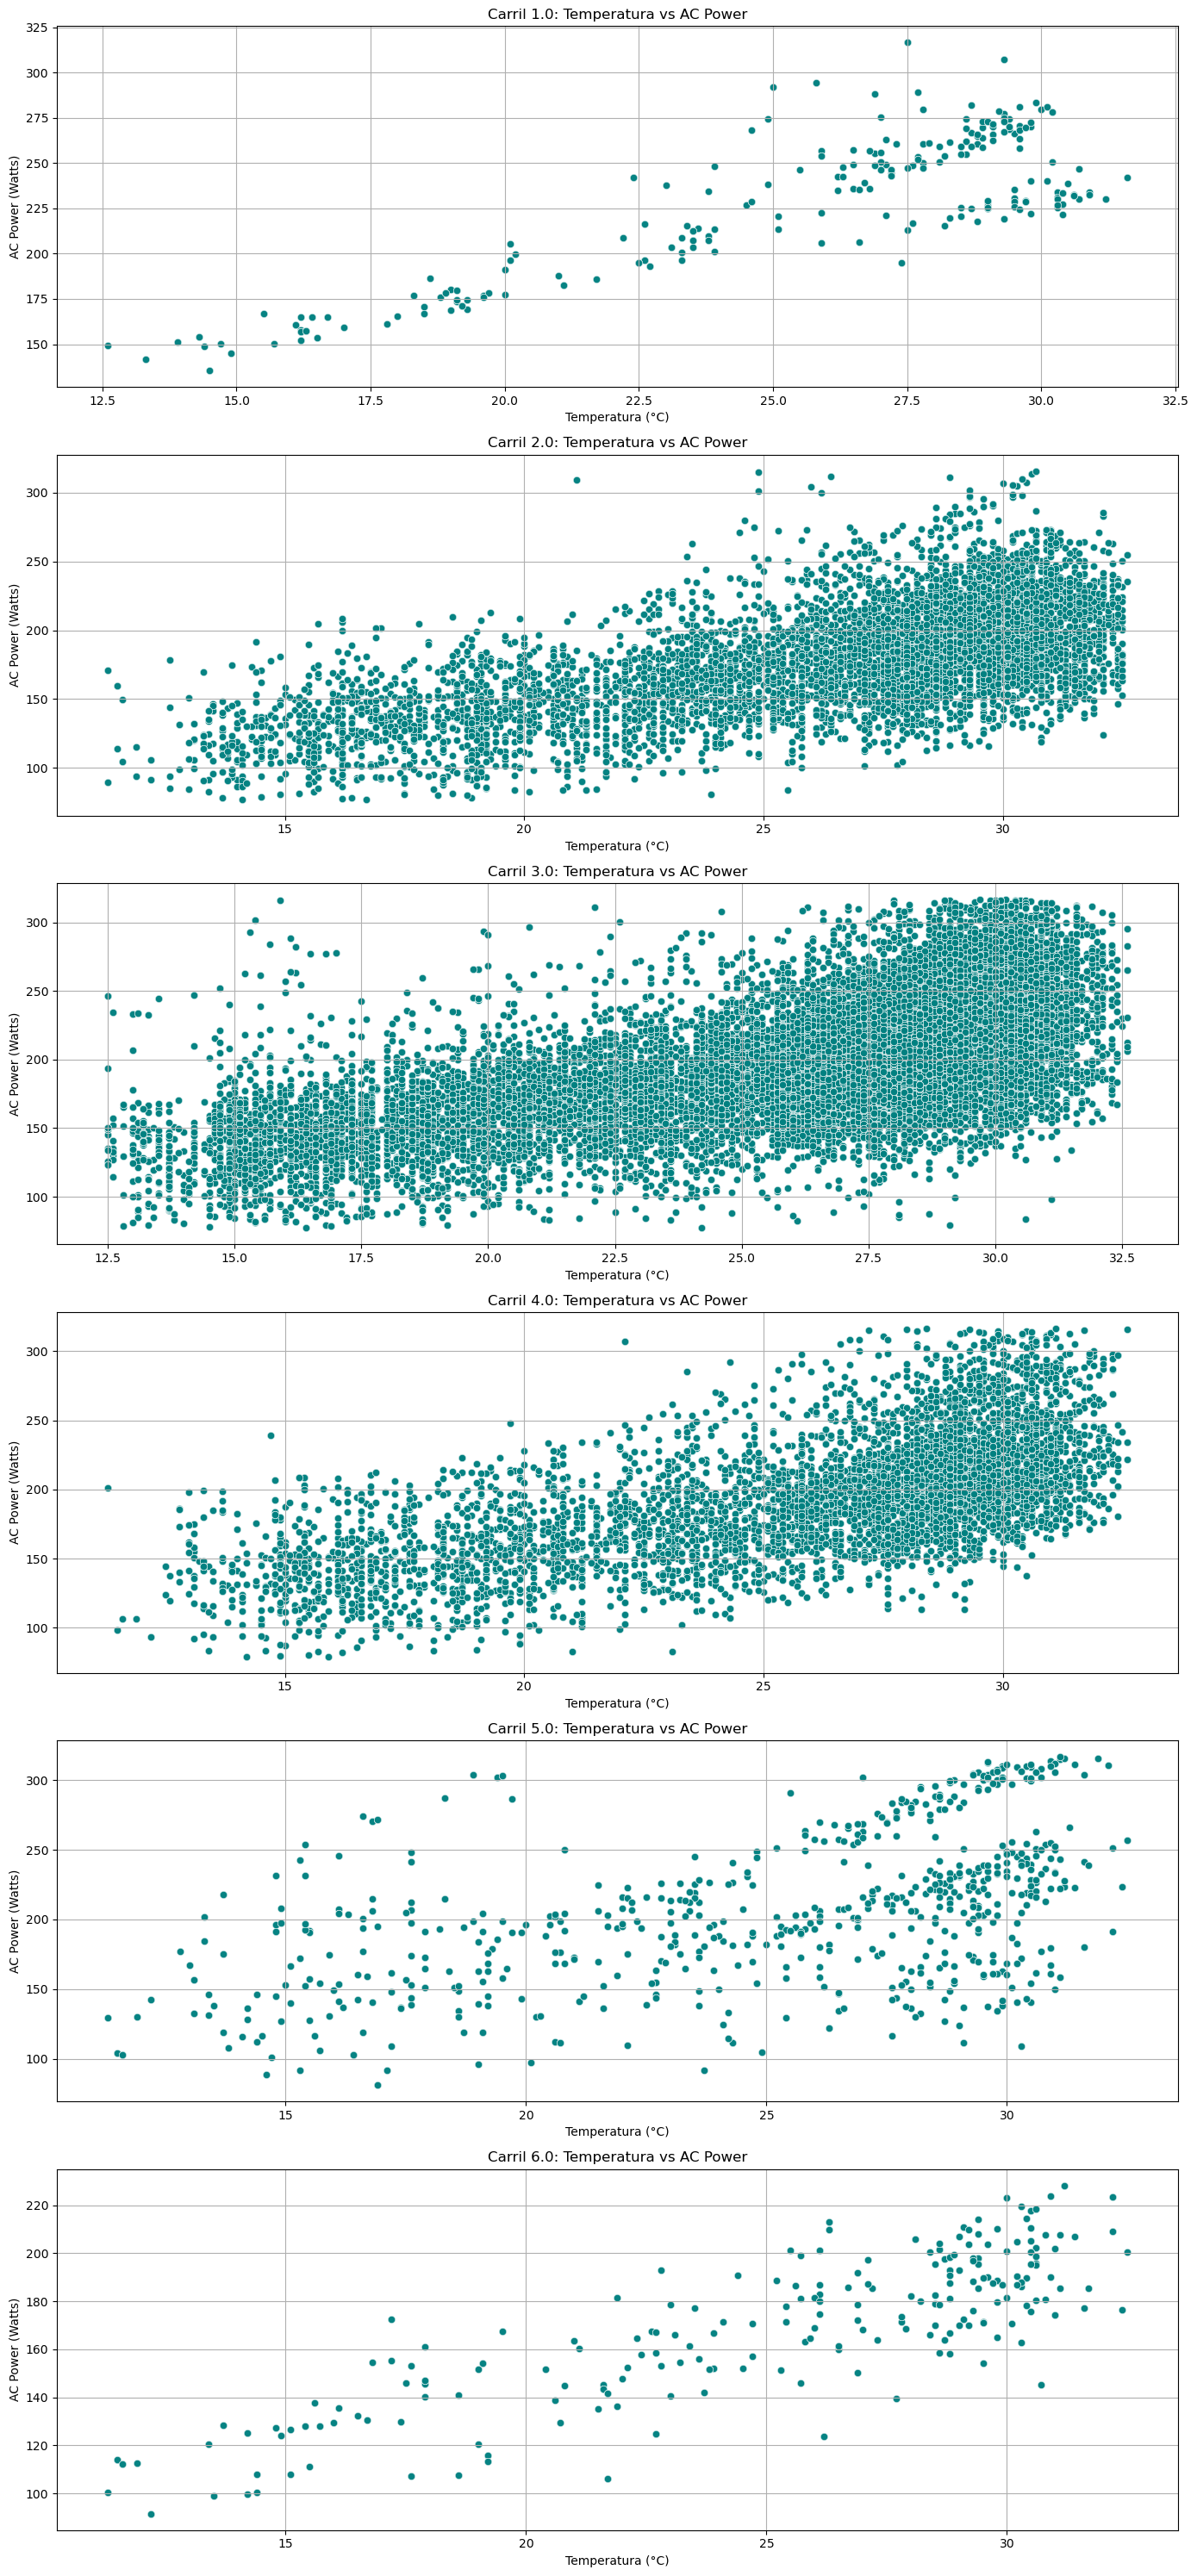

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Cargar y limpiar dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'ac_power_watts']].dropna()

# === 2. Eliminar outliers con IQR en ac_power_watts ===
Q1 = df['ac_power_watts'].quantile(0.25)
Q3 = df['ac_power_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['ac_power_watts'] >= lower) & (df['ac_power_watts'] <= upper)]

# === 3. Graficar temperatura vs ac_power_watts para cada número de carriles ===
unique_lanes = sorted(df_clean['lane count'].unique())

plt.figure(figsize=(14, 5 * len(unique_lanes)))

for i, lane in enumerate(unique_lanes, 1):
    df_lane = df_clean[df_clean['lane count'] == lane]
    plt.subplot(len(unique_lanes), 1, i)
    sns.scatterplot(data=df_lane, x='temperature', y='ac_power_watts', alpha=0.6, color='teal')
    # Opcional: línea de regresión
    # sns.regplot(data=df_lane, x='temperature', y='ac_power_watts', scatter=False, color='red')
    plt.title(f"Carril {lane}: Temperatura vs AC Power")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("AC Power (Watts)")
    plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2583309949.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


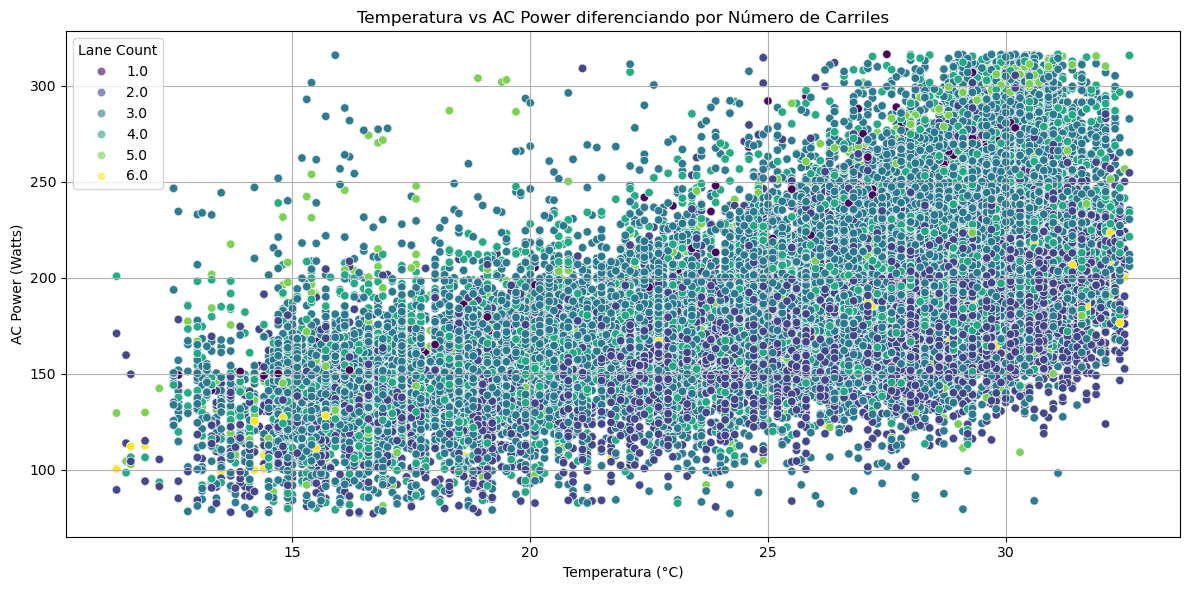

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar datos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'ac_power_watts']].dropna()

# === 2. Eliminar outliers por IQR ===
Q1 = df['ac_power_watts'].quantile(0.25)
Q3 = df['ac_power_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['ac_power_watts'] >= lower) & (df['ac_power_watts'] <= upper)]

# === 3. Gráfico combinado con hue por número de carriles ===
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_clean,
    x='temperature',
    y='ac_power_watts',
    hue='lane count',
    palette='viridis',
    alpha=0.6
)
plt.title("Temperatura vs AC Power diferenciando por Número de Carriles")
plt.xlabel("Temperatura (°C)")
plt.ylabel("AC Power (Watts)")
plt.grid(True)
plt.legend(title="Lane Count")
plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1359579636.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


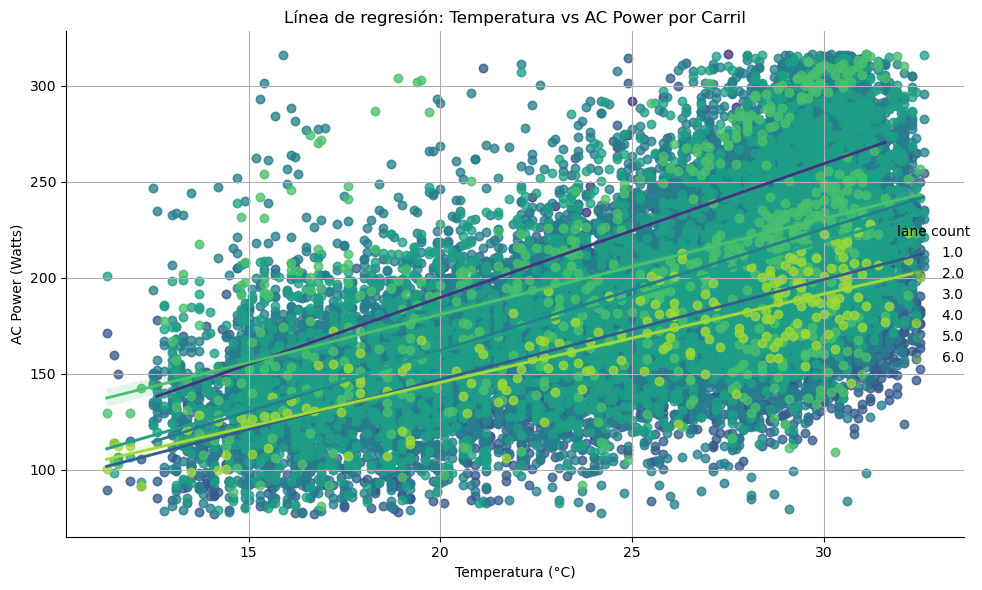

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar datos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'ac_power_watts']].dropna()

# === 2. Eliminar outliers por IQR ===
Q1 = df['ac_power_watts'].quantile(0.25)
Q3 = df['ac_power_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['ac_power_watts'] >= lower) & (df['ac_power_watts'] <= upper)]

# === 3. Gráfico con líneas de regresión para cada grupo ===
sns.lmplot(
    data=df_clean,
    x='temperature',
    y='ac_power_watts',
    hue='lane count',
    palette='viridis',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.3},
    line_kws={'linewidth': 2}
)

plt.title("Línea de regresión: Temperatura vs AC Power por Carril")
plt.xlabel("Temperatura (°C)")
plt.ylabel("AC Power (Watts)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1710535718.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


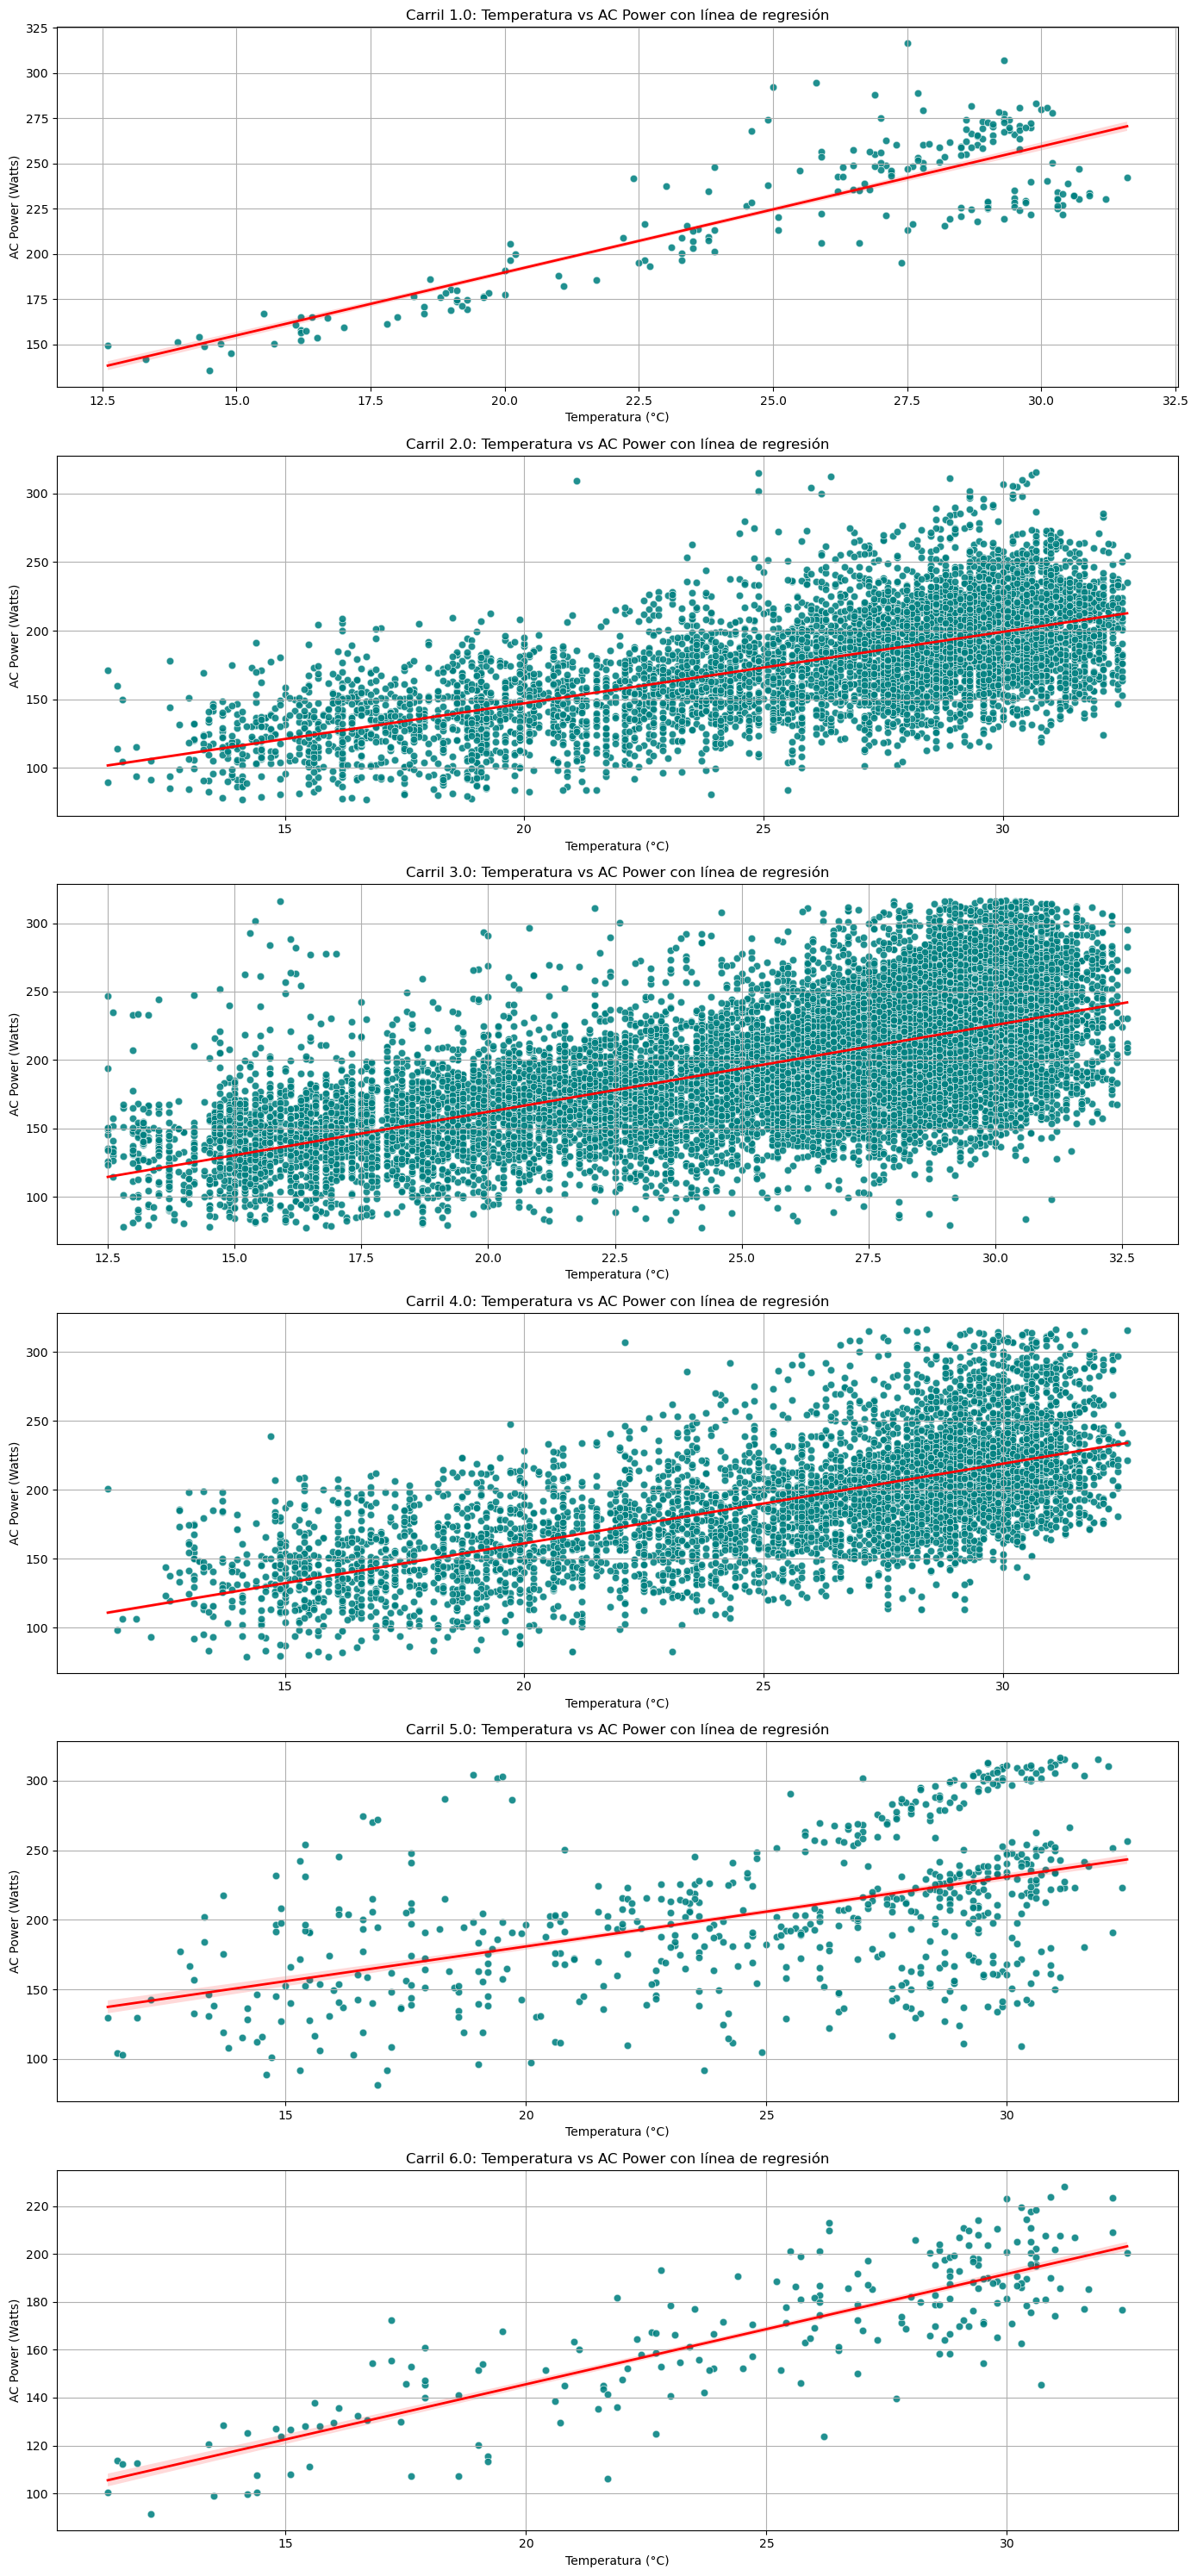

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Cargar y limpiar datos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['temperature', 'lane count', 'ac_power_watts']].dropna()

# === 2. Eliminar outliers (IQR sobre ac_power_watts) ===
Q1 = df['ac_power_watts'].quantile(0.25)
Q3 = df['ac_power_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['ac_power_watts'] >= lower) & (df['ac_power_watts'] <= upper)]

# === 3. Gráficas individuales con línea de regresión ===
unique_lanes = sorted(df_clean['lane count'].unique())
plt.figure(figsize=(14, 5 * len(unique_lanes)))

for i, lane in enumerate(unique_lanes, 1):
    df_lane = df_clean[df_clean['lane count'] == lane]
    plt.subplot(len(unique_lanes), 1, i)
    
    # Puntos
    sns.scatterplot(data=df_lane, x='temperature', y='ac_power_watts', alpha=0.4, color='teal')
    
    # Línea de regresión
    sns.regplot(
        data=df_lane,
        x='temperature',
        y='ac_power_watts',
        scatter=False,
        color='red',
        line_kws={"linewidth": 2}
    )
    
    plt.title(f"Carril {lane}: Temperatura vs AC Power con línea de regresión")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("AC Power (Watts)")
    plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\3608165103.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")
C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\3608165103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_summer'] = df_clean['date'].dt.month.isin([6, 7, 8])


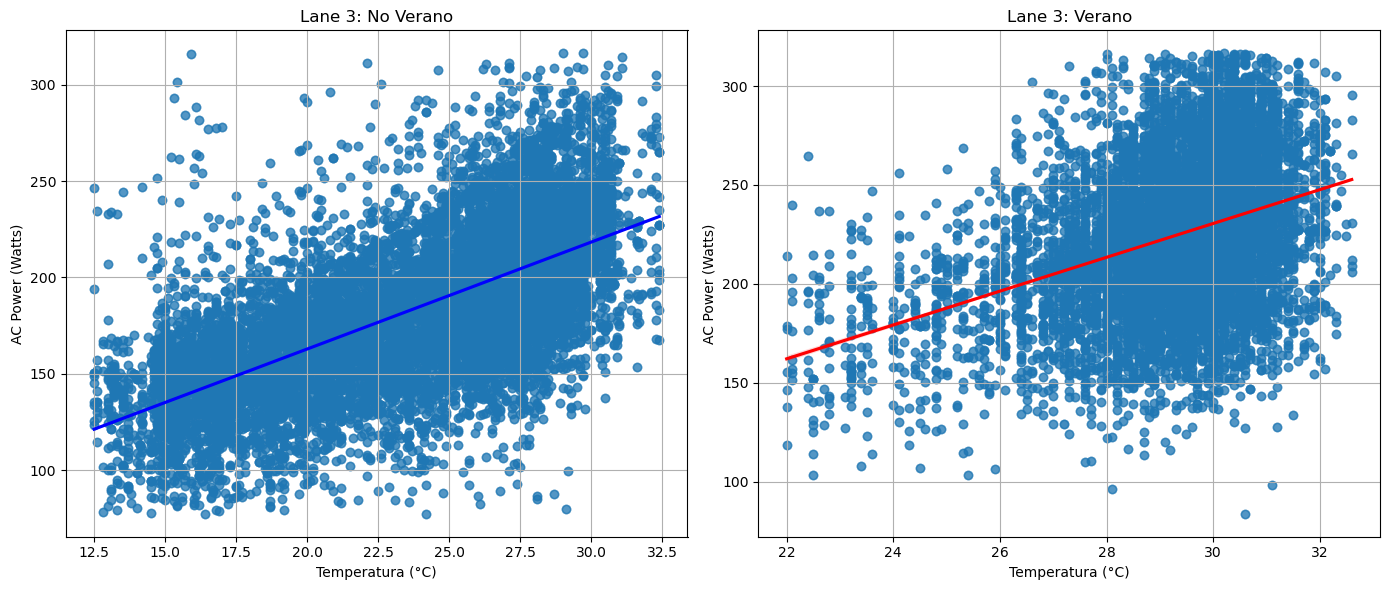

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Cargar y preparar dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['date', 'temperature', 'lane count', 'ac_power_watts']].dropna()
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === 2. Eliminar outliers en ac_power_watts ===
Q1 = df['ac_power_watts'].quantile(0.25)
Q3 = df['ac_power_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['ac_power_watts'] >= lower) & (df['ac_power_watts'] <= upper)]

# === 3. Clasificar por temporada (verano) ===
df_clean['is_summer'] = df_clean['date'].dt.month.isin([6, 7, 8])

# === 4. Graficar summer vs non-summer para un carril específico (por ejemplo: lane = 3) ===
lane_id = 3
df_lane = df_clean[df_clean['lane count'] == lane_id]

plt.figure(figsize=(14, 6))

# No Verano
plt.subplot(1, 2, 1)
sns.regplot(
    data=df_lane[df_lane['is_summer'] == False],
    x='temperature',
    y='ac_power_watts',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'blue'}
)
plt.title(f"Lane {lane_id}: No Verano")
plt.xlabel("Temperatura (°C)")
plt.ylabel("AC Power (Watts)")
plt.grid(True)

# Verano
plt.subplot(1, 2, 2)
sns.regplot(
    data=df_lane[df_lane['is_summer'] == True],
    x='temperature',
    y='ac_power_watts',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title(f"Lane {lane_id}: Verano")
plt.xlabel("Temperatura (°C)")
plt.ylabel("AC Power (Watts)")
plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1013400769.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")
C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1013400769.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_summer'] = df_clean['date'].dt.month.isin([6, 7, 8])


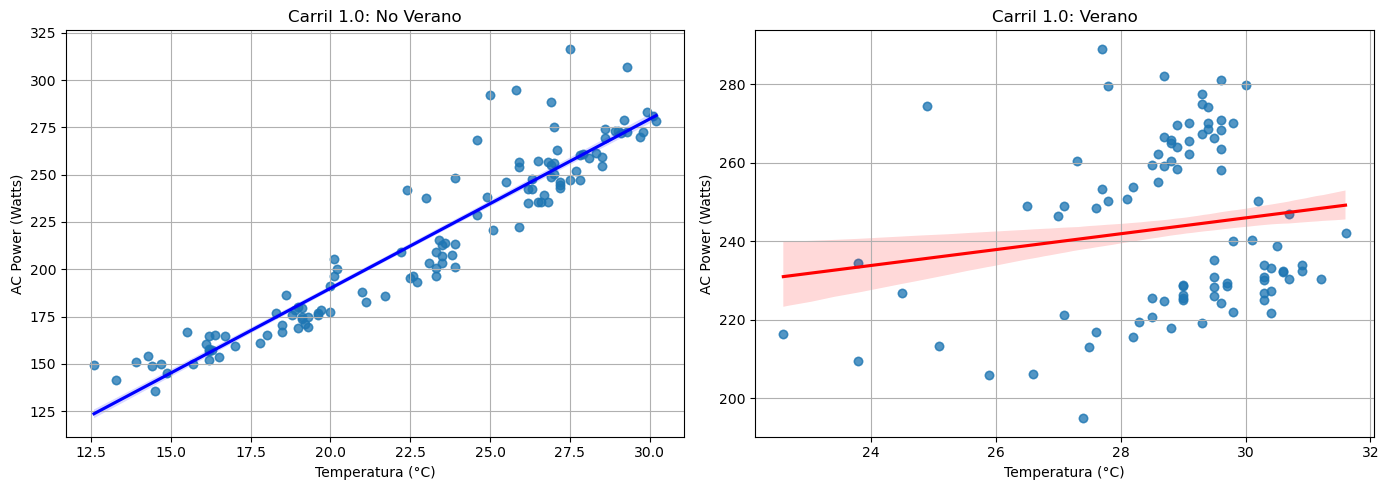

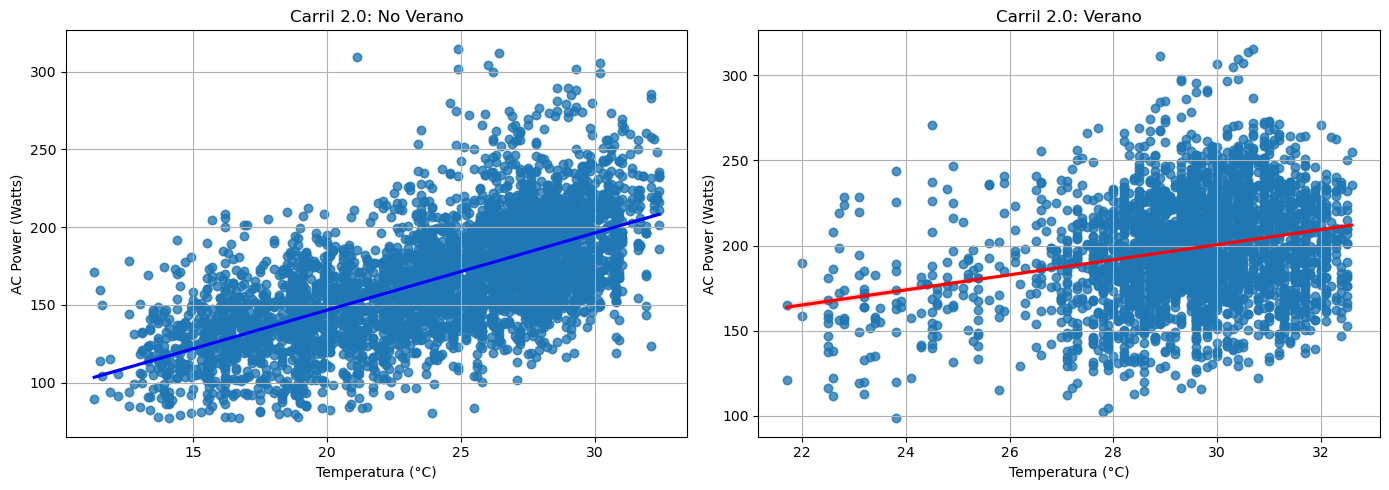

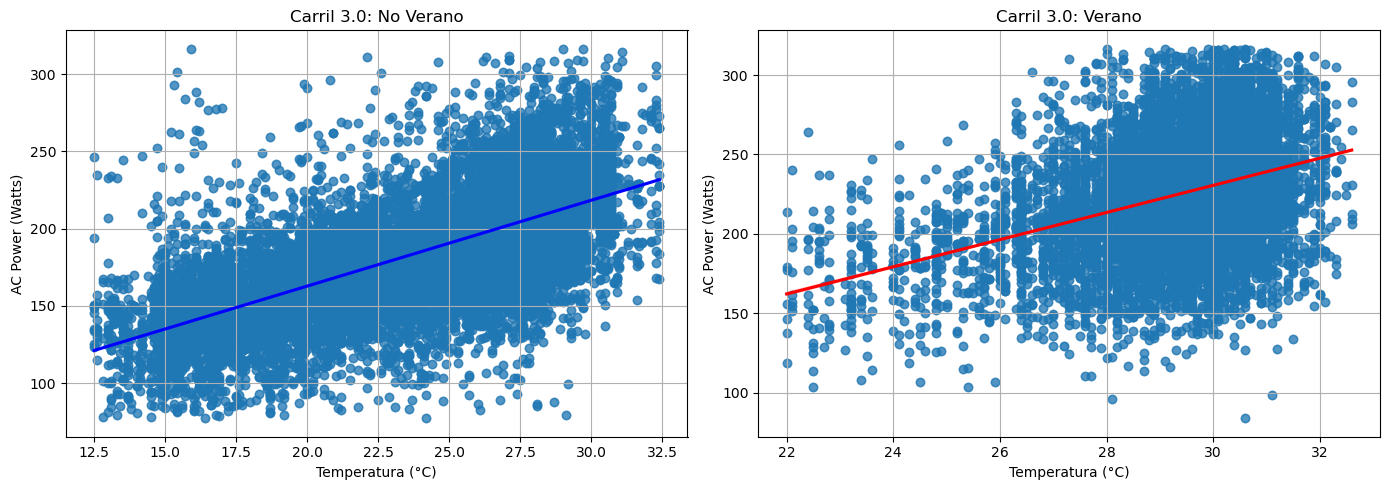

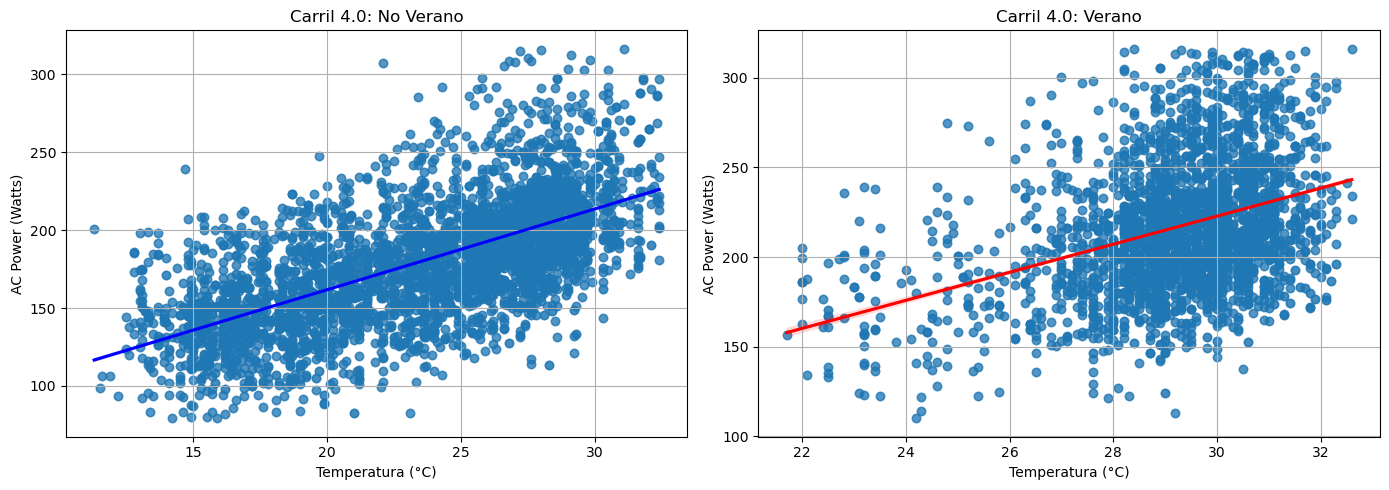

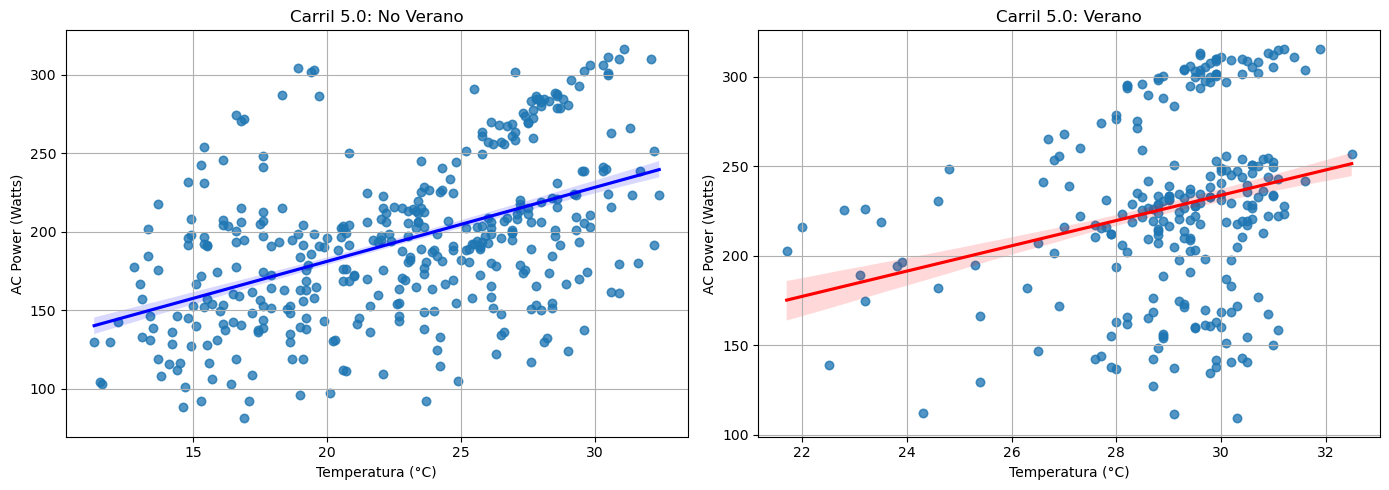

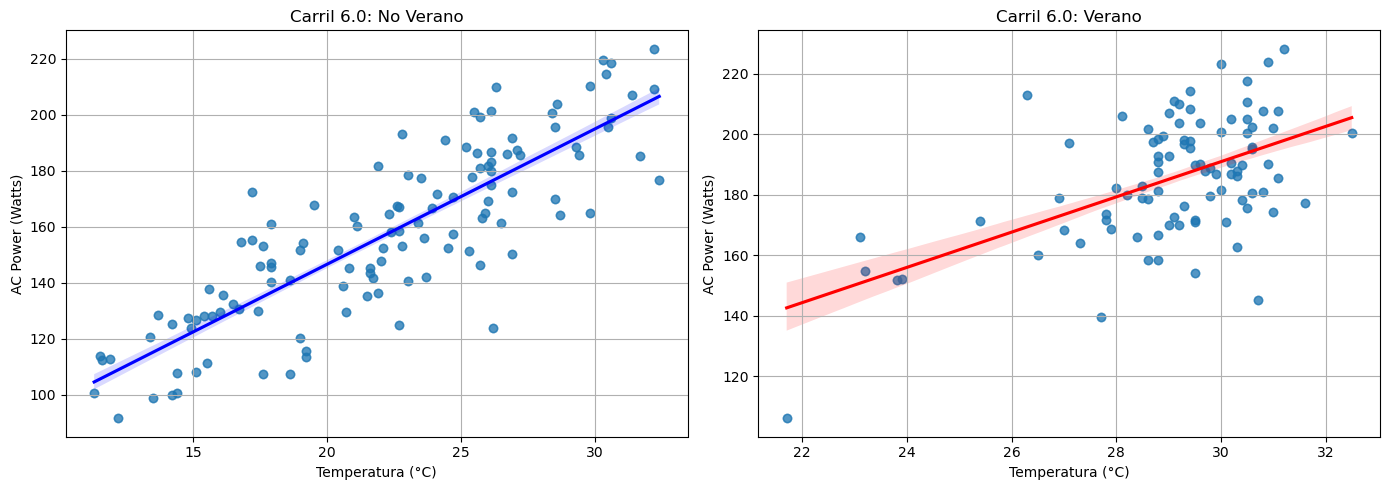

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar datos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['date', 'temperature', 'lane count', 'ac_power_watts']].dropna()
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === 2. Eliminar outliers en ac_power_watts ===
Q1 = df['ac_power_watts'].quantile(0.25)
Q3 = df['ac_power_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['ac_power_watts'] >= lower) & (df['ac_power_watts'] <= upper)]

# === 3. Clasificar verano / no verano ===
df_clean['is_summer'] = df_clean['date'].dt.month.isin([6, 7, 8])

# === 4. Lista de carriles únicos ===
unique_lanes = sorted(df_clean['lane count'].unique())

# === 5. Graficar por cada carril ===
for lane_id in unique_lanes:
    df_lane = df_clean[df_clean['lane count'] == lane_id]
    
    plt.figure(figsize=(14, 5))
    
    # No Verano
    plt.subplot(1, 2, 1)
    sns.regplot(
        data=df_lane[df_lane['is_summer'] == False],
        x='temperature',
        y='ac_power_watts',
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'blue'}
    )
    plt.title(f"Carril {lane_id}: No Verano")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("AC Power (Watts)")
    plt.grid(True)
    
    # Verano
    plt.subplot(1, 2, 2)
    sns.regplot(
        data=df_lane[df_lane['is_summer'] == True],
        x='temperature',
        y='ac_power_watts',
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'}
    )
    plt.title(f"Carril {lane_id}: Verano")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("AC Power (Watts)")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1212771235.py:6: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")
C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1212771235.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_summer'] = df_clean['date'].dt.month.isin([6, 7, 8])


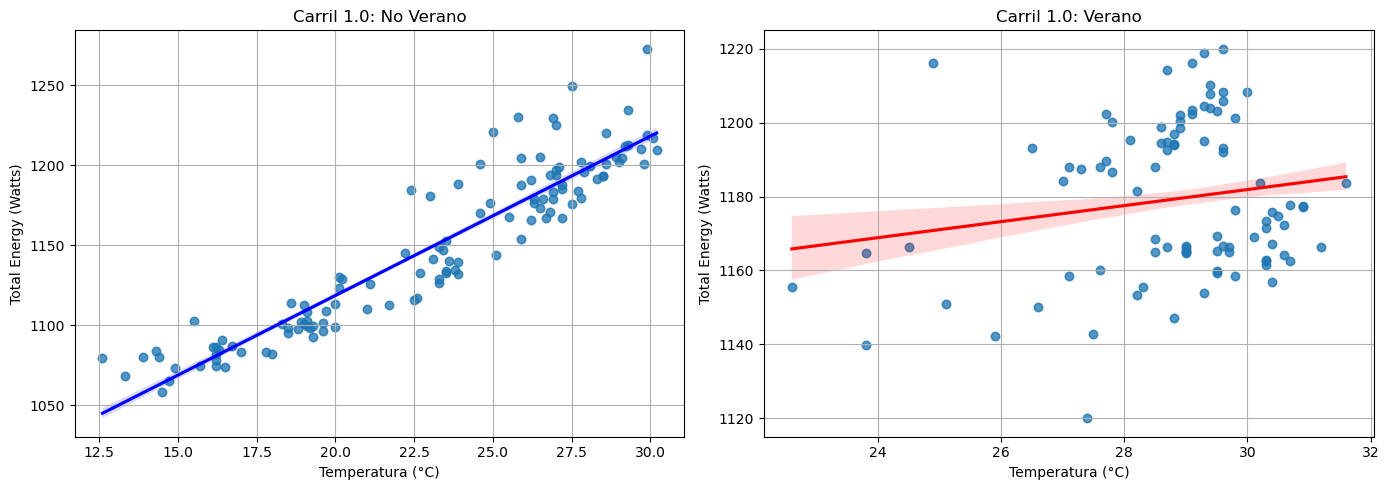

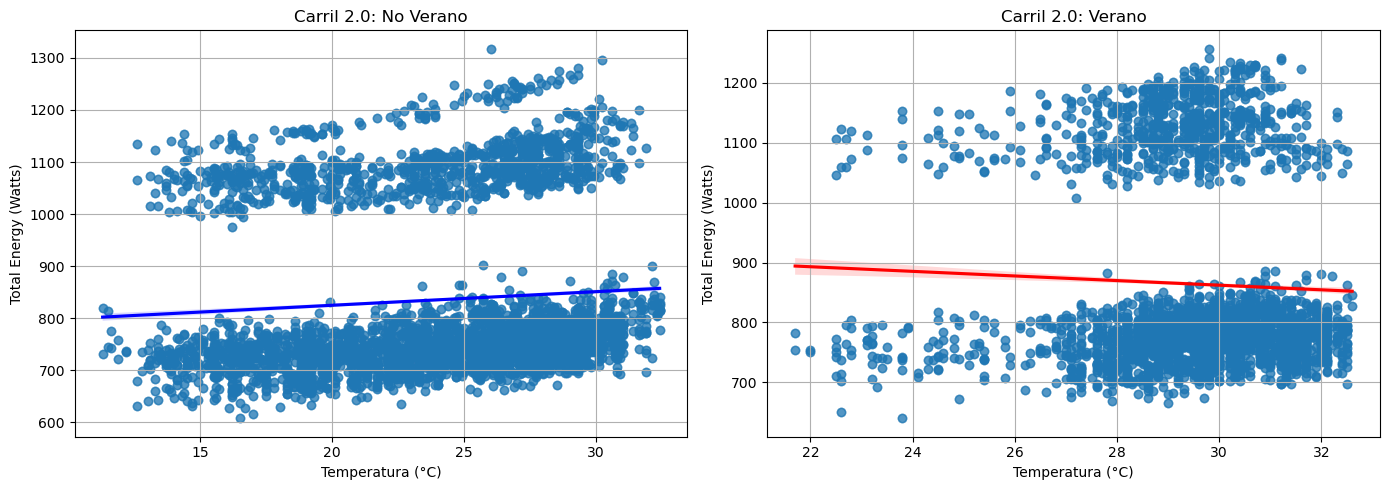

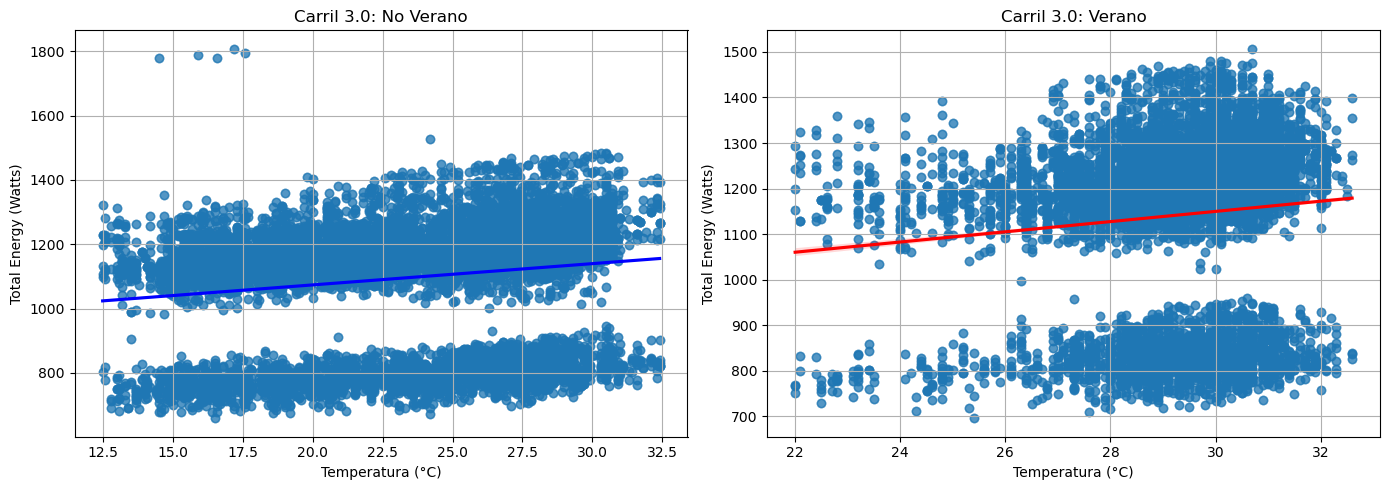

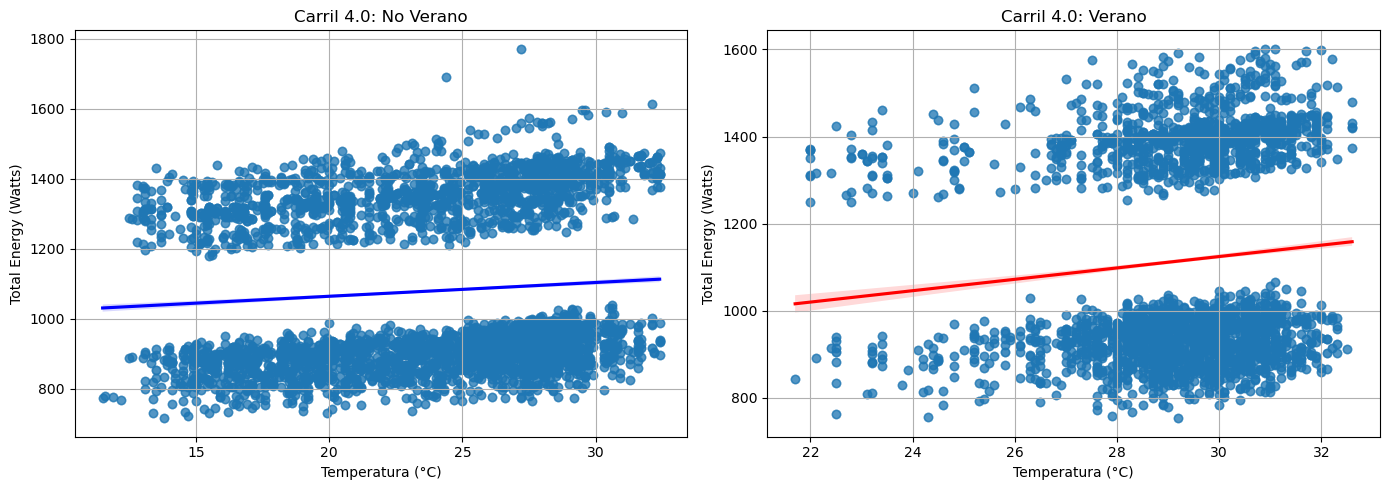

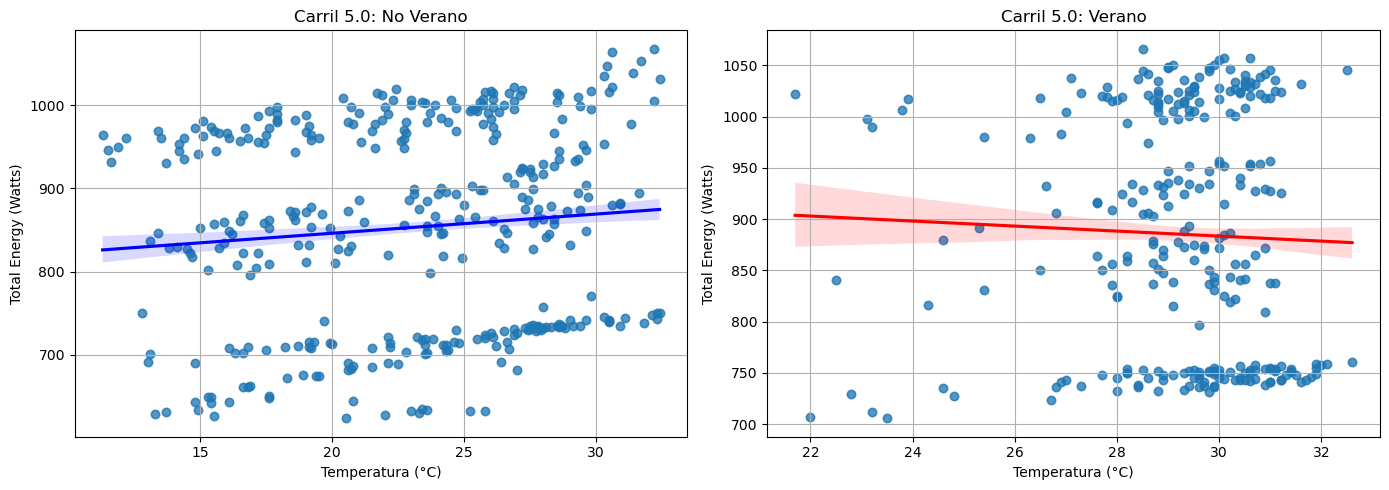

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar datos ===
df = pd.read_csv("TrainingDataSet.csv")
df = df[['date', 'temperature', 'lane count', 'total_energy_watts']].dropna()
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# === 2. Eliminar outliers en total_energy_watts ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df_clean = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Clasificar verano / no verano ===
df_clean['is_summer'] = df_clean['date'].dt.month.isin([6, 7, 8])

# === 4. Lista de carriles únicos ===
unique_lanes = sorted(df_clean['lane count'].unique())

# === 5. Graficar para cada carril ===
for lane_id in unique_lanes:
    df_lane = df_clean[df_clean['lane count'] == lane_id]
    
    plt.figure(figsize=(14, 5))
    
    # No Verano
    plt.subplot(1, 2, 1)
    sns.regplot(
        data=df_lane[df_lane['is_summer'] == False],
        x='temperature',
        y='total_energy_watts',
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'blue'}
    )
    plt.title(f"Carril {lane_id}: No Verano")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Total Energy (Watts)")
    plt.grid(True)
    
    # Verano
    plt.subplot(1, 2, 2)
    sns.regplot(
        data=df_lane[df_lane['is_summer'] == True],
        x='temperature',
        y='total_energy_watts',
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'}
    )
    plt.title(f"Carril {lane_id}: Verano")
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Total Energy (Watts)")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2174959612.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


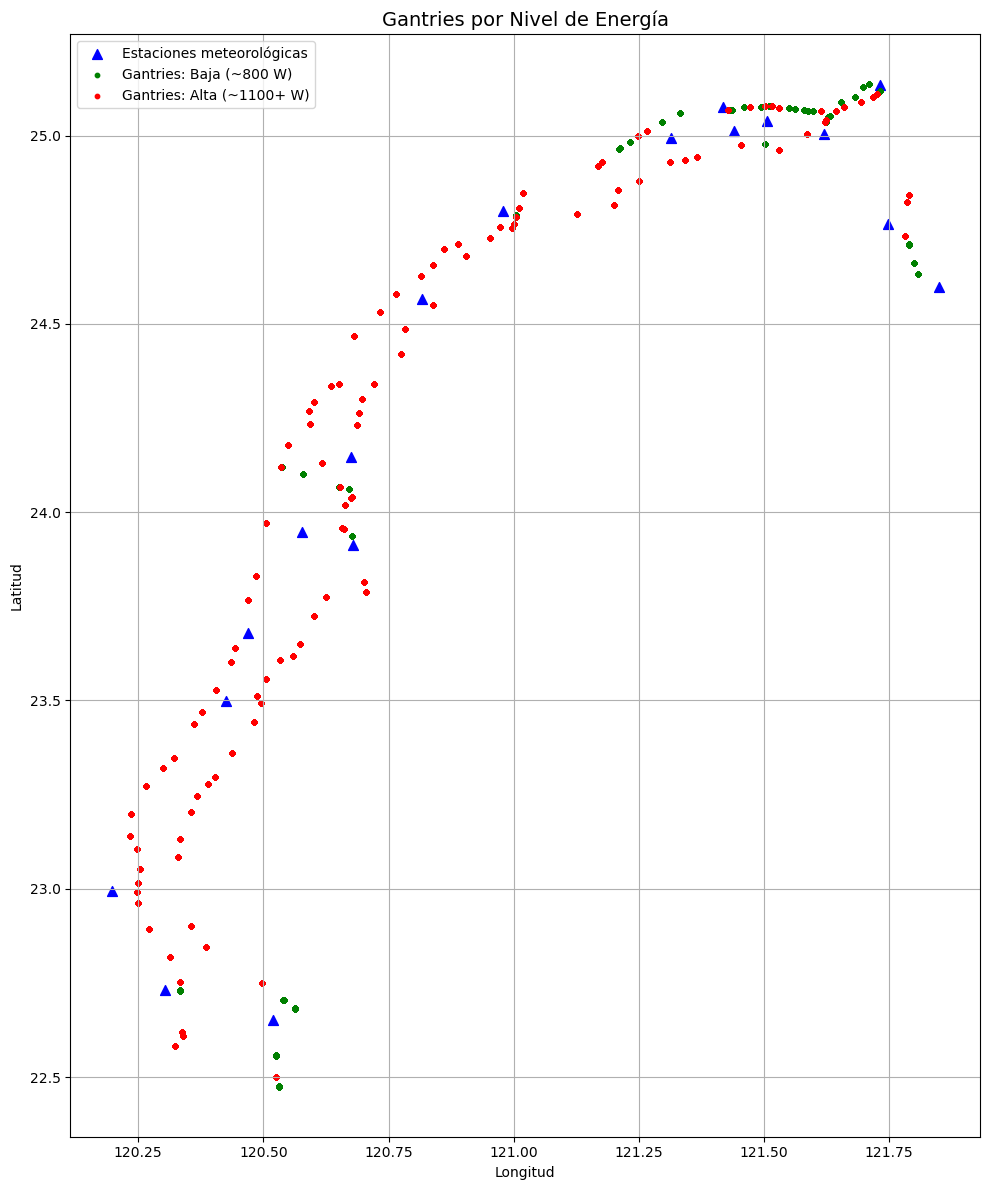

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar datos ===
df = pd.read_csv("training_ready_dataset_balltree.csv")

# === 2. Filtrar datos válidos ===
df = df.dropna(subset=['temperature', 'station_latitude', 'station_longitude', 'total_energy_watts'])

# === 3. Eliminar outliers en energía ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 4. Clasificar por nivel de energía ===
df['energy_group'] = df['total_energy_watts'].apply(lambda x: 'Baja (~800)' if x < 950 else 'Alta (~1100+)')

# === 5. Crear figura del mapa ===
plt.figure(figsize=(10, 12))
plt.title("Gantries por Nivel de Energía", fontsize=14)

# Estaciones meteorológicas (azul, marcador triángulo)
stations = df[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
plt.scatter(
    stations['station_longitude'], stations['station_latitude'],
    color='blue', label='Estaciones meteorológicas', s=50, marker='^'
)

# Gantries por nivel energético
plt.scatter(
    df[df['energy_group'] == 'Baja (~800)']['longitude'],
    df[df['energy_group'] == 'Baja (~800)']['latitude'],
    color='green', label='Gantries: Baja (~800 W)', s=10
)
plt.scatter(
    df[df['energy_group'] == 'Alta (~1100+)']['longitude'],
    df[df['energy_group'] == 'Alta (~1100+)']['latitude'],
    color='red', label='Gantries: Alta (~1100+ W)', s=10
)

# Estilo del gráfico
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gantry_energy_groups_map.png", dpi=300)
plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1961126519.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


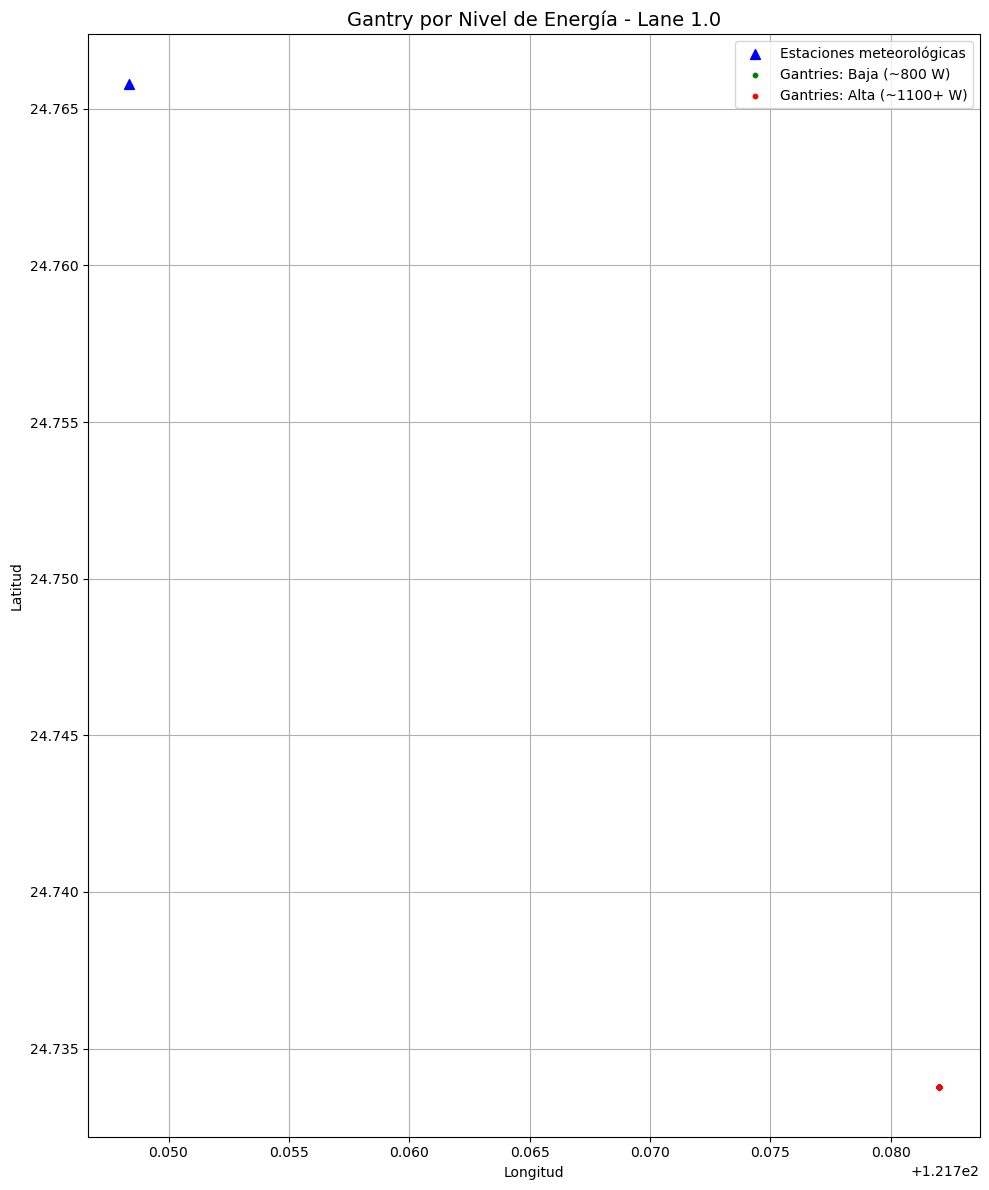

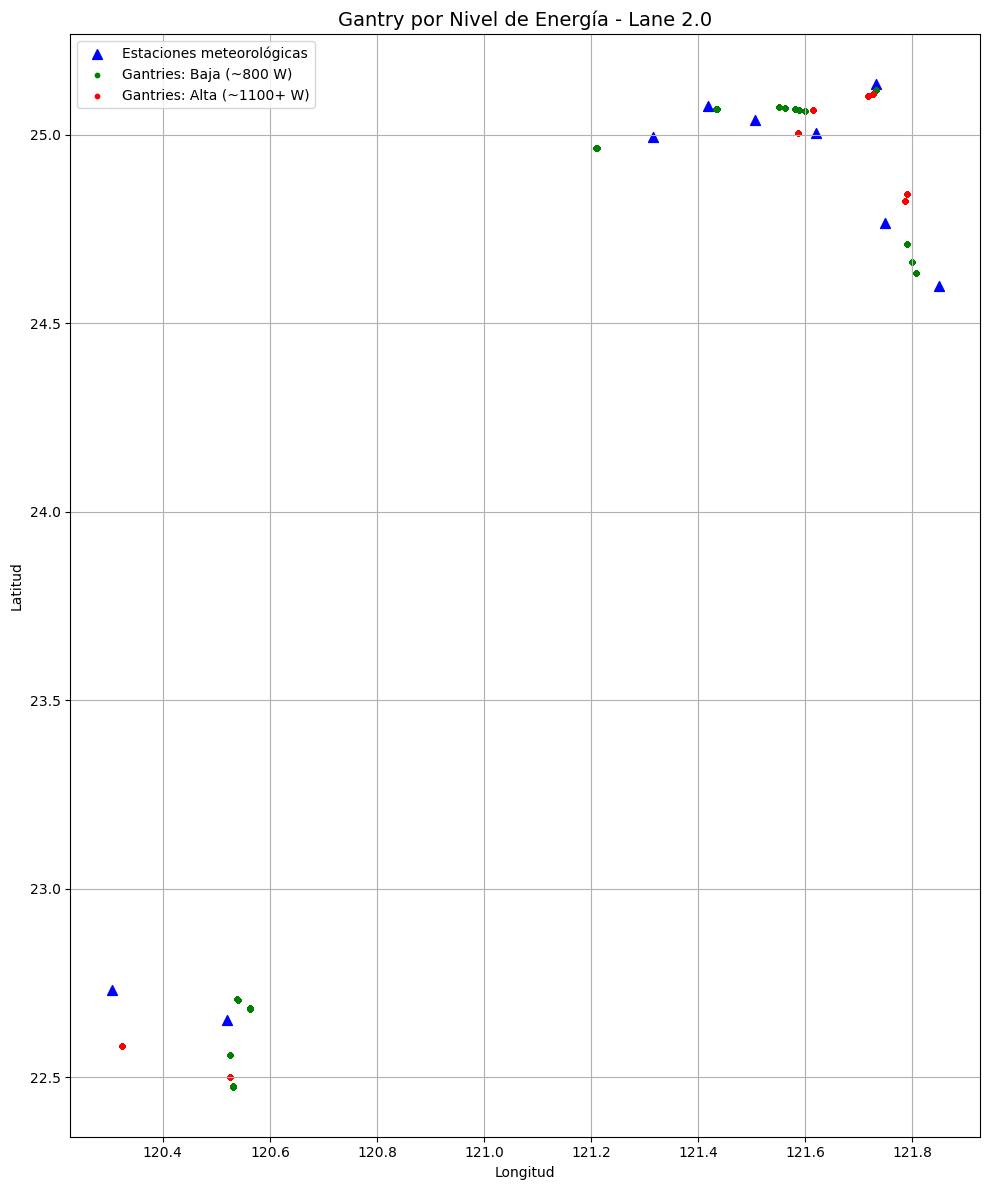

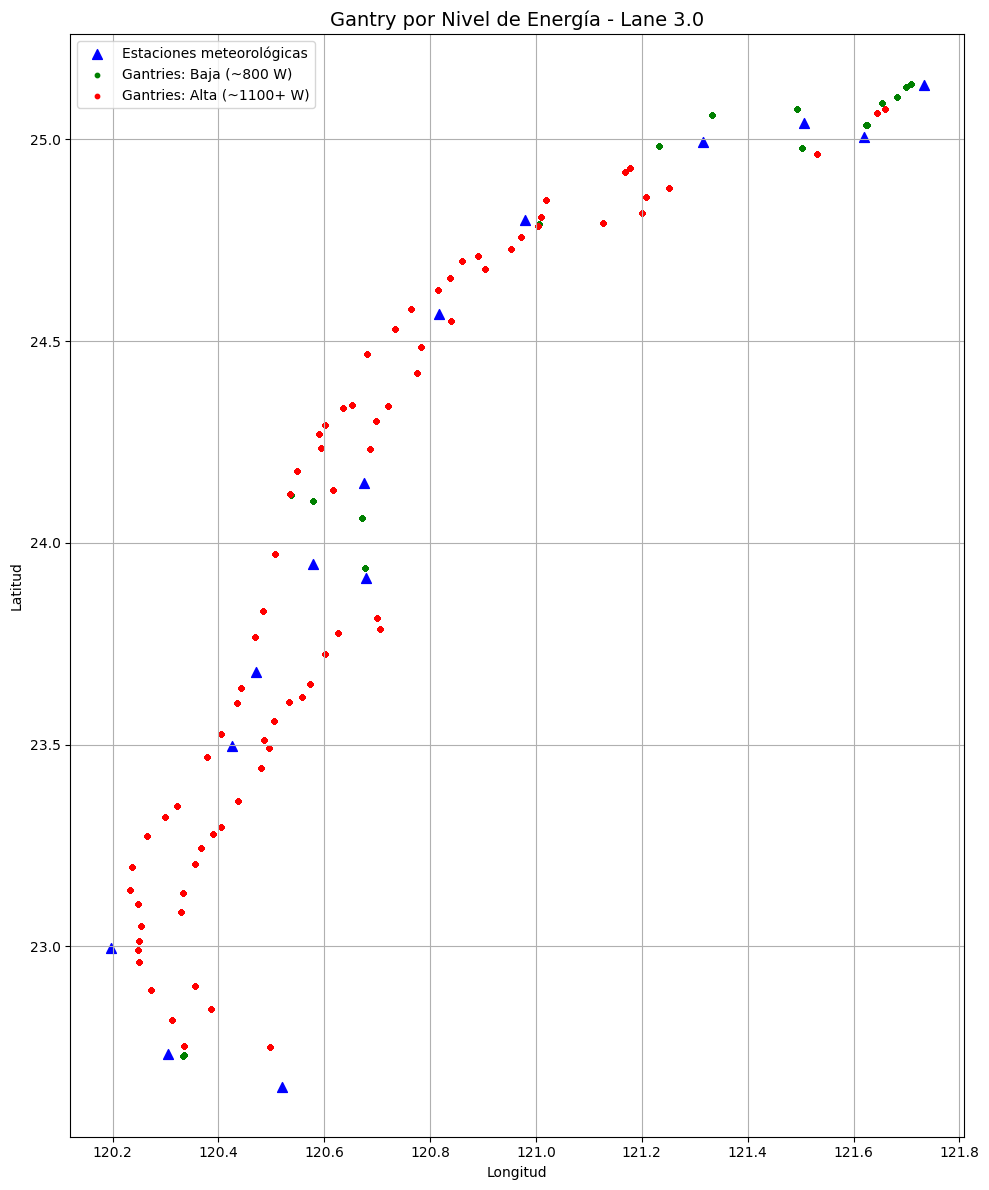

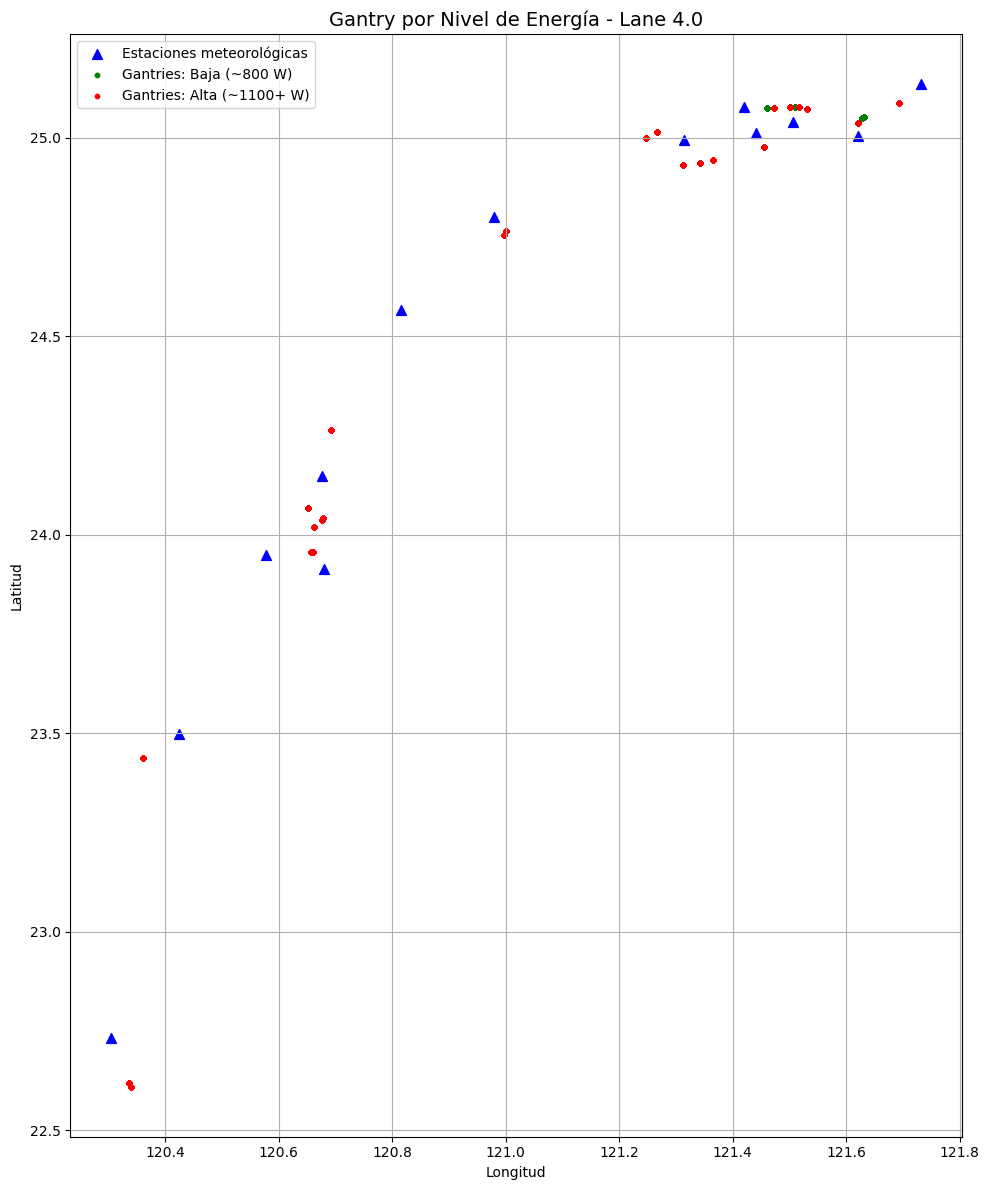

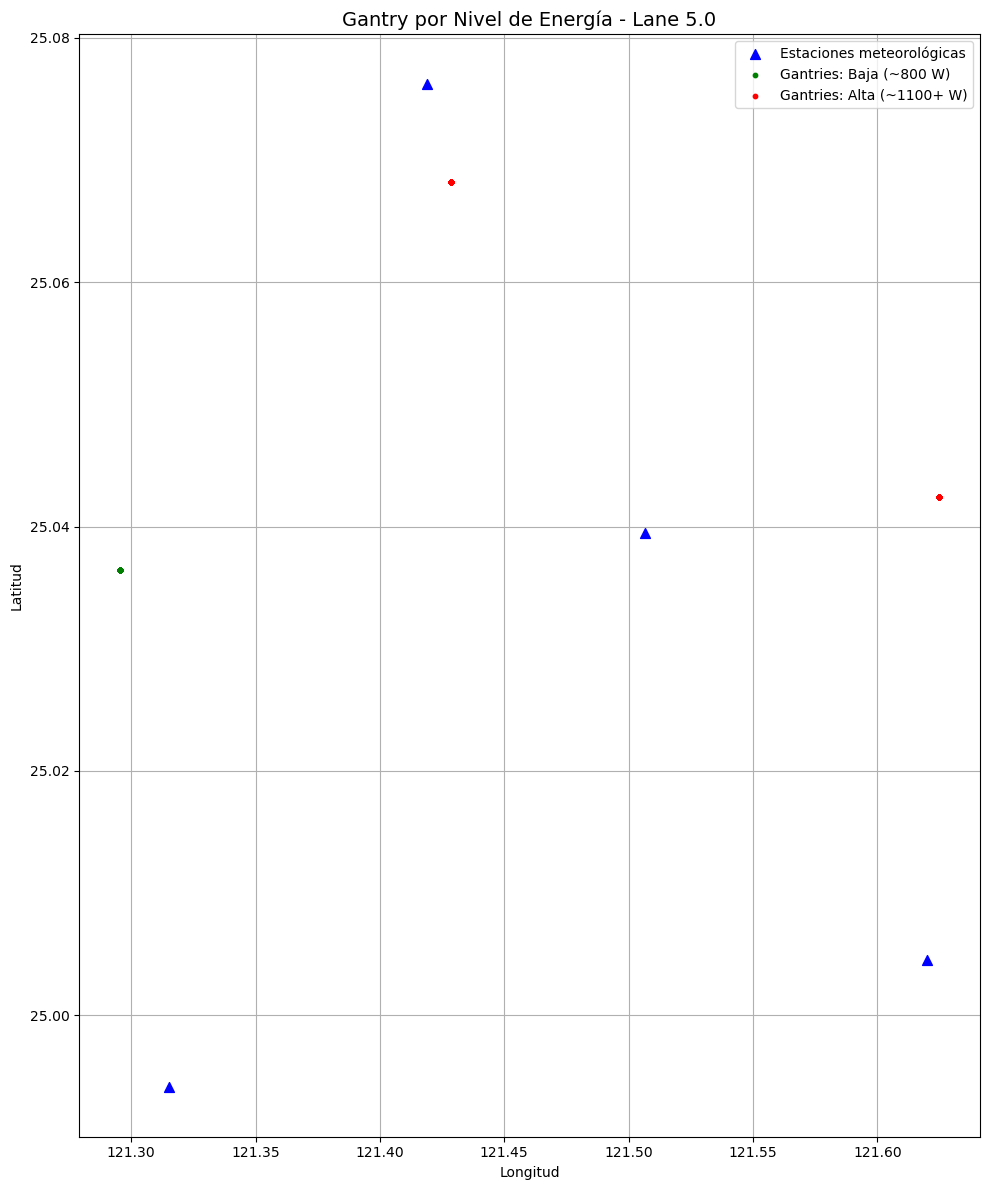

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar datos ===
df = pd.read_csv("training_ready_dataset_balltree.csv")
df = df.dropna(subset=[
    'temperature', 'lane count', 'total_energy_watts',
    'latitude', 'longitude', 'station_latitude', 'station_longitude'
])

# === 2. Eliminar outliers por IQR ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Clasificar por grupo de energía ===
df['energy_group'] = df['total_energy_watts'].apply(lambda x: 'Baja (~800)' if x < 950 else 'Alta (~1100+)')

# === 4. Obtener los valores únicos de carriles ===
lane_groups = sorted(df['lane count'].unique())

# === 5. Generar un mapa por cada número de carril ===
for lane in lane_groups:
    lane_df = df[df['lane count'] == lane]
    
    plt.figure(figsize=(10, 12))
    plt.title(f"Gantry por Nivel de Energía - Lane {lane}", fontsize=14)

    # Estaciones (azul)
    stations = lane_df[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
    plt.scatter(
        stations['station_longitude'], stations['station_latitude'],
        color='blue', label='Estaciones meteorológicas', s=50, marker='^'
    )

    # Gantries: Baja (~800W)
    plt.scatter(
        lane_df[lane_df['energy_group'] == 'Baja (~800)']['longitude'],
        lane_df[lane_df['energy_group'] == 'Baja (~800)']['latitude'],
        color='green', label='Gantries: Baja (~800 W)', s=10
    )

    # Gantries: Alta (~1100+W)
    plt.scatter(
        lane_df[lane_df['energy_group'] == 'Alta (~1100+)']['longitude'],
        lane_df[lane_df['energy_group'] == 'Alta (~1100+)']['latitude'],
        color='red', label='Gantries: Alta (~1100+ W)', s=10
    )

    # Formato del mapa
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2425782113.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


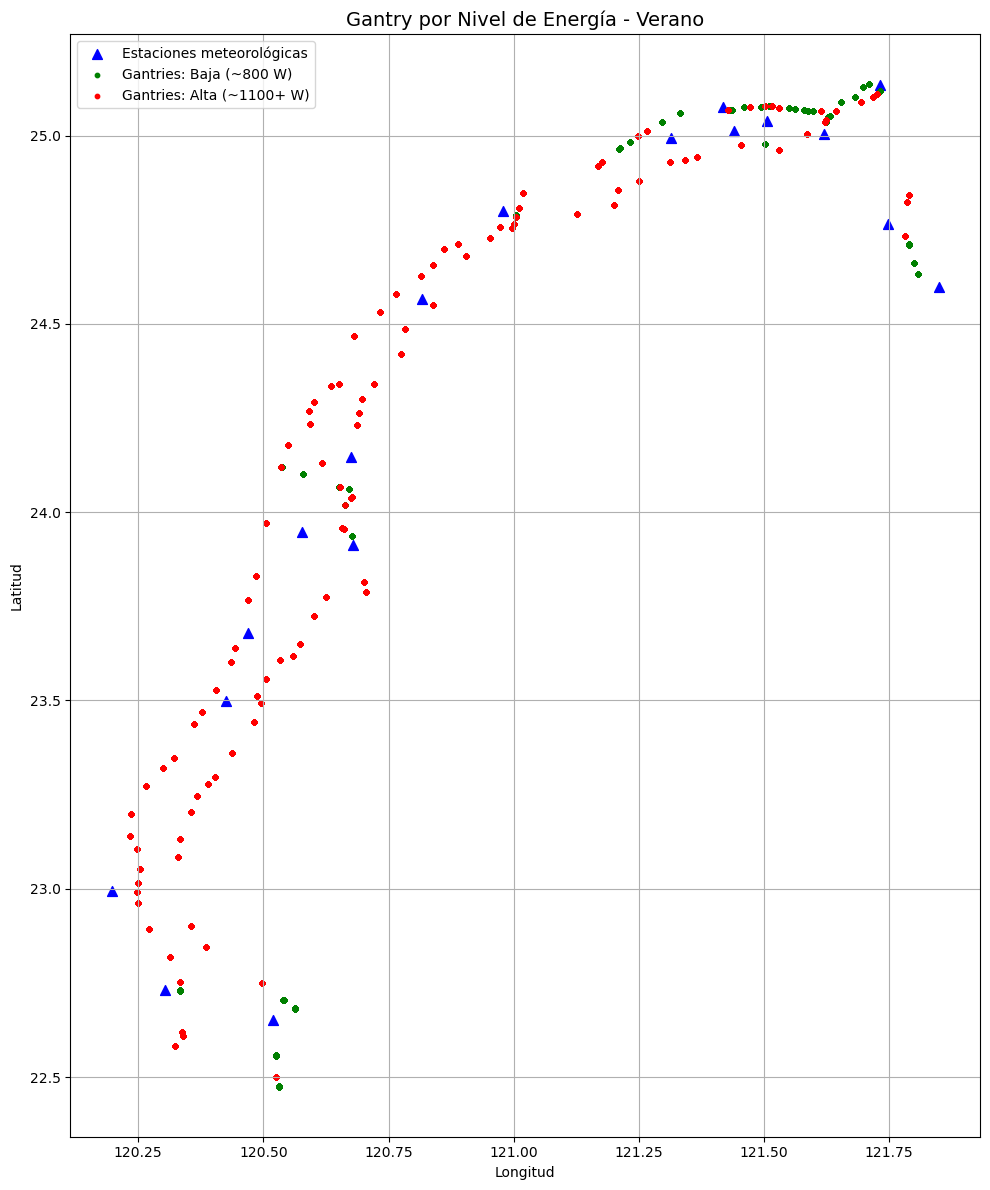

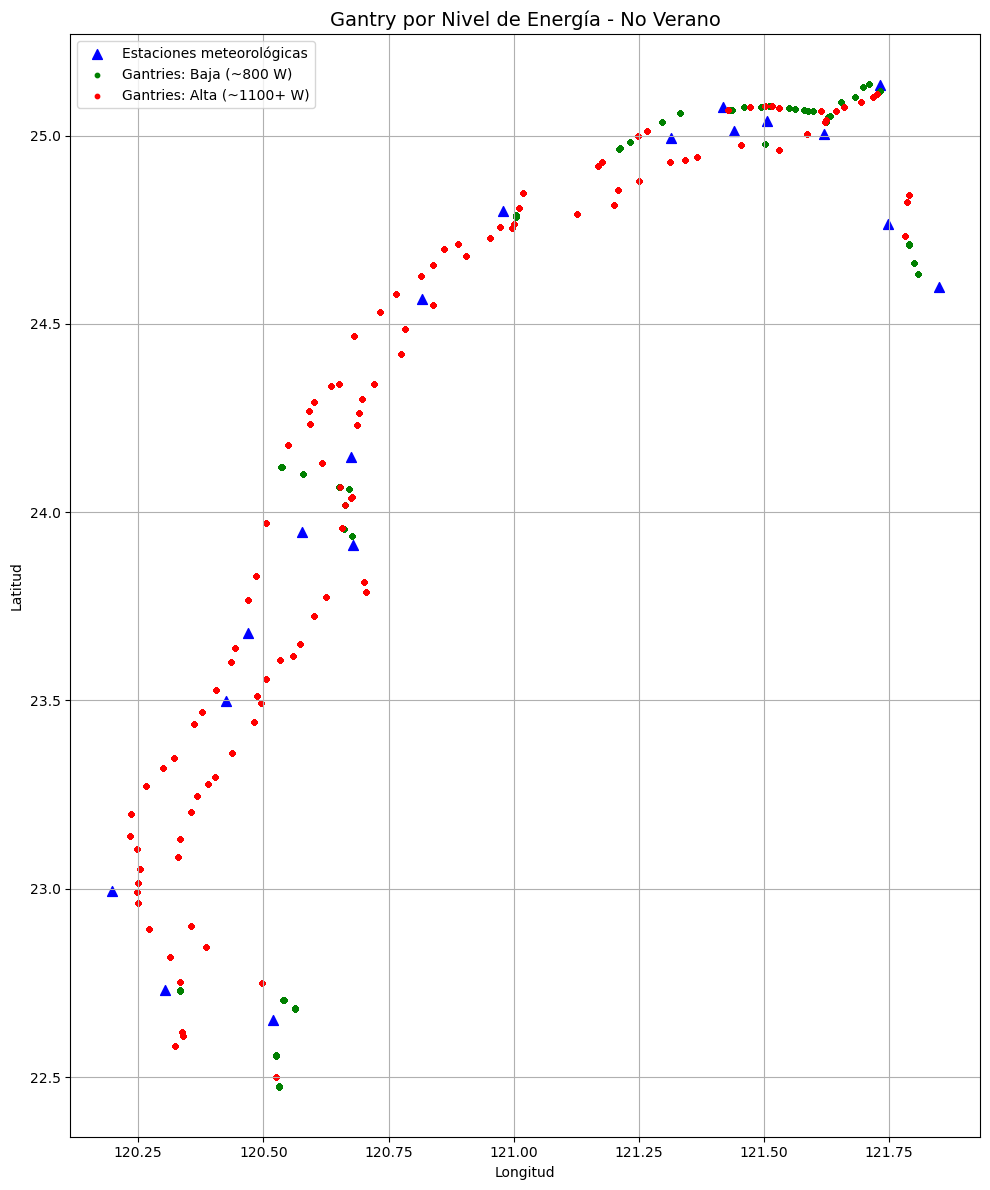

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar y preparar dataset ===
df = pd.read_csv("training_ready_dataset_balltree.csv")

# === 2. Filtrar columnas necesarias y eliminar nulos ===
df = df.dropna(subset=[
    'date', 'temperature', 'lane count', 'total_energy_watts',
    'latitude', 'longitude', 'station_latitude', 'station_longitude'
])

# === 3. Convertir fecha y clasificar temporada ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['is_summer'] = df['date'].dt.month.isin([6, 7, 8])

# === 4. Eliminar outliers en energía (IQR) ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 5. Clasificar por grupo energético ===
df['energy_group'] = df['total_energy_watts'].apply(lambda x: 'Baja (~800)' if x < 950 else 'Alta (~1100+)')

# === 6. Función para graficar según temporada ===
def plot_gantry_energy_by_season(df_subset, season_label):
    plt.figure(figsize=(10, 12))
    plt.title(f"Gantry por Nivel de Energía - {season_label}", fontsize=14)

    # Estaciones (azul)
    stations = df_subset[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
    plt.scatter(
        stations['station_longitude'], stations['station_latitude'],
        color='blue', label='Estaciones meteorológicas', s=50, marker='^'
    )

    # Gantries: baja energía
    plt.scatter(
        df_subset[df_subset['energy_group'] == 'Baja (~800)']['longitude'],
        df_subset[df_subset['energy_group'] == 'Baja (~800)']['latitude'],
        color='green', label='Gantries: Baja (~800 W)', s=10
    )

    # Gantries: alta energía
    plt.scatter(
        df_subset[df_subset['energy_group'] == 'Alta (~1100+)']['longitude'],
        df_subset[df_subset['energy_group'] == 'Alta (~1100+)']['latitude'],
        color='red', label='Gantries: Alta (~1100+ W)', s=10
    )

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 7. Generar mapas ===
plot_gantry_energy_by_season(df[df['is_summer']], "Verano")
plot_gantry_energy_by_season(df[~df['is_summer']], "No Verano")


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2661449728.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


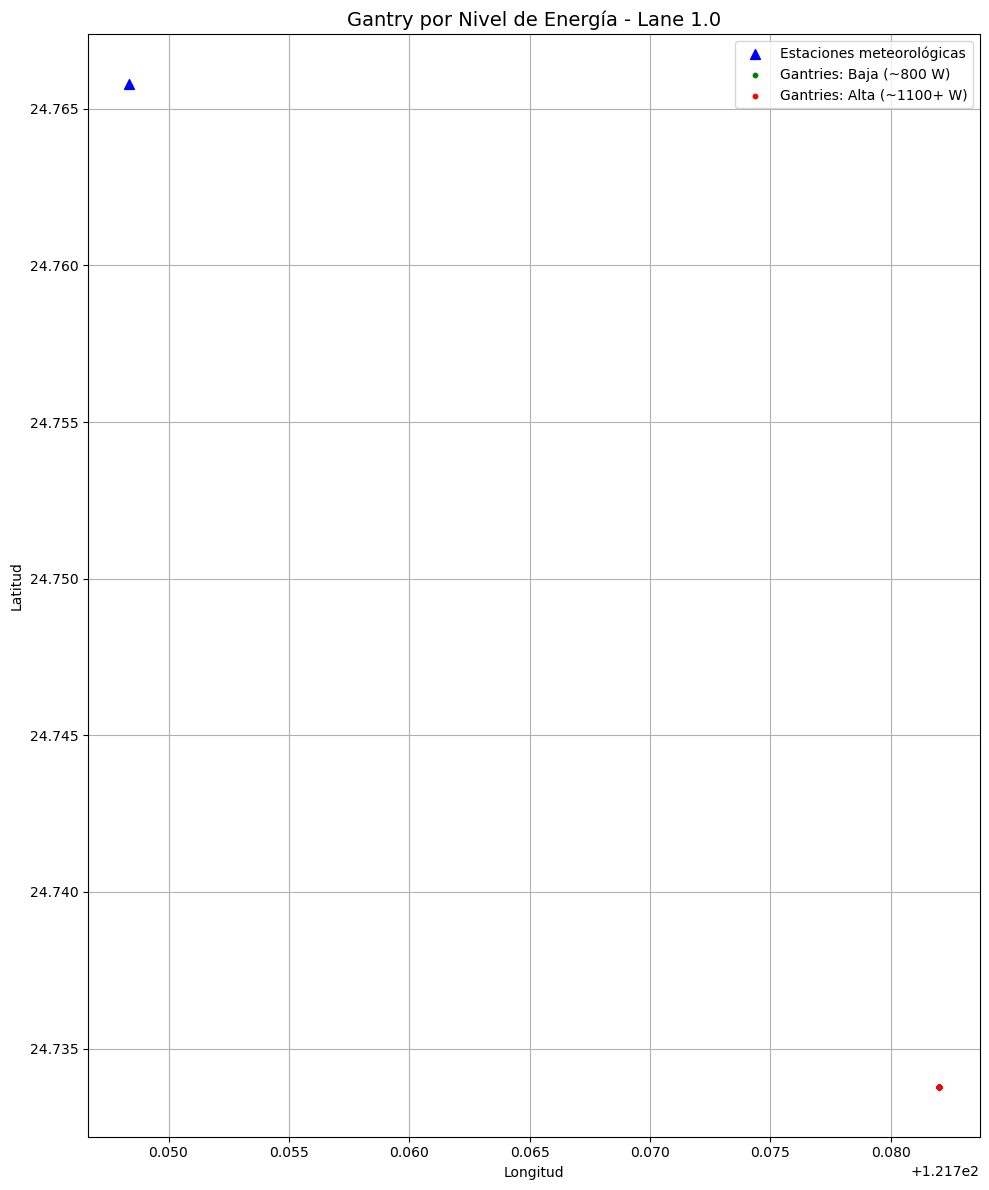

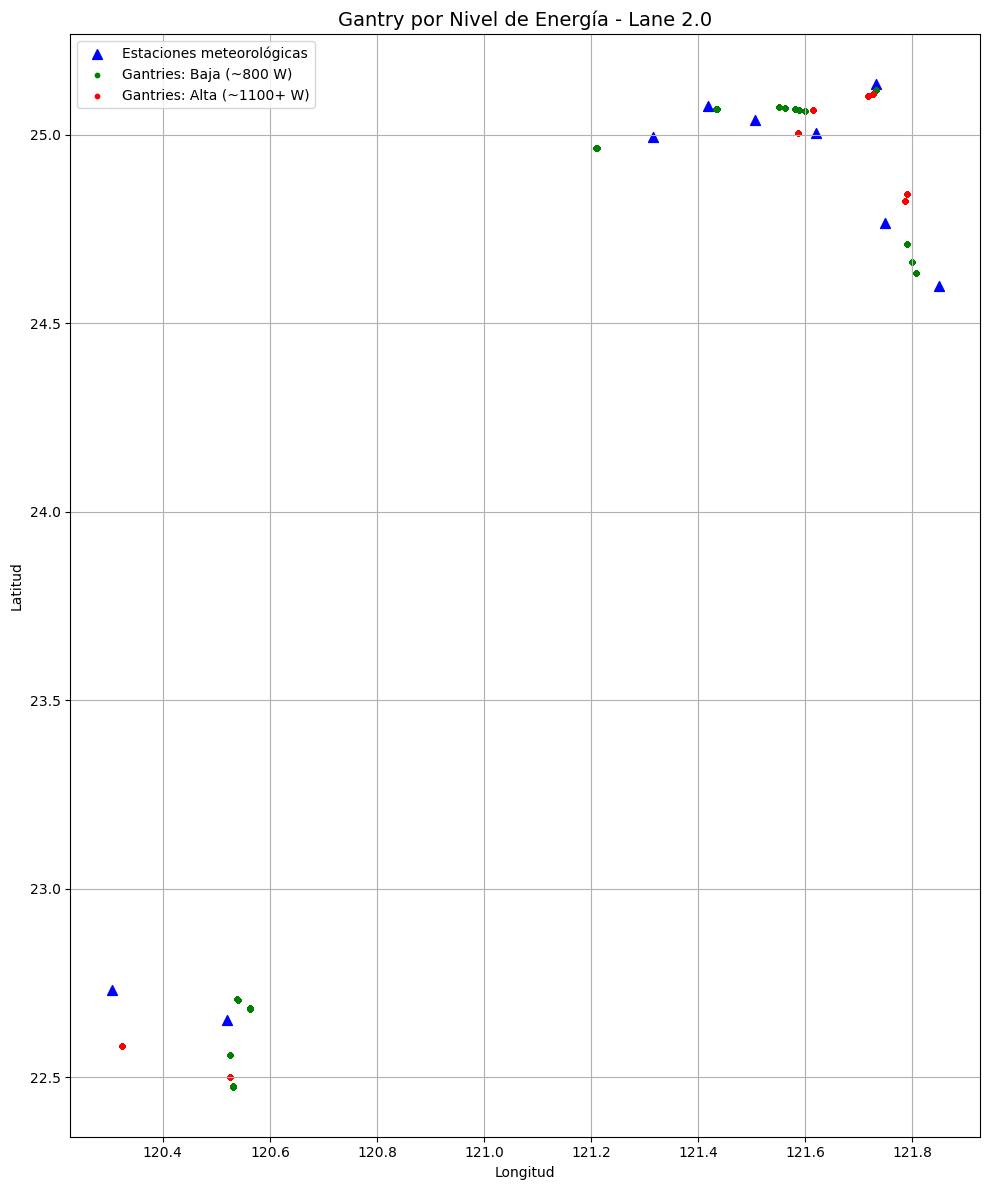

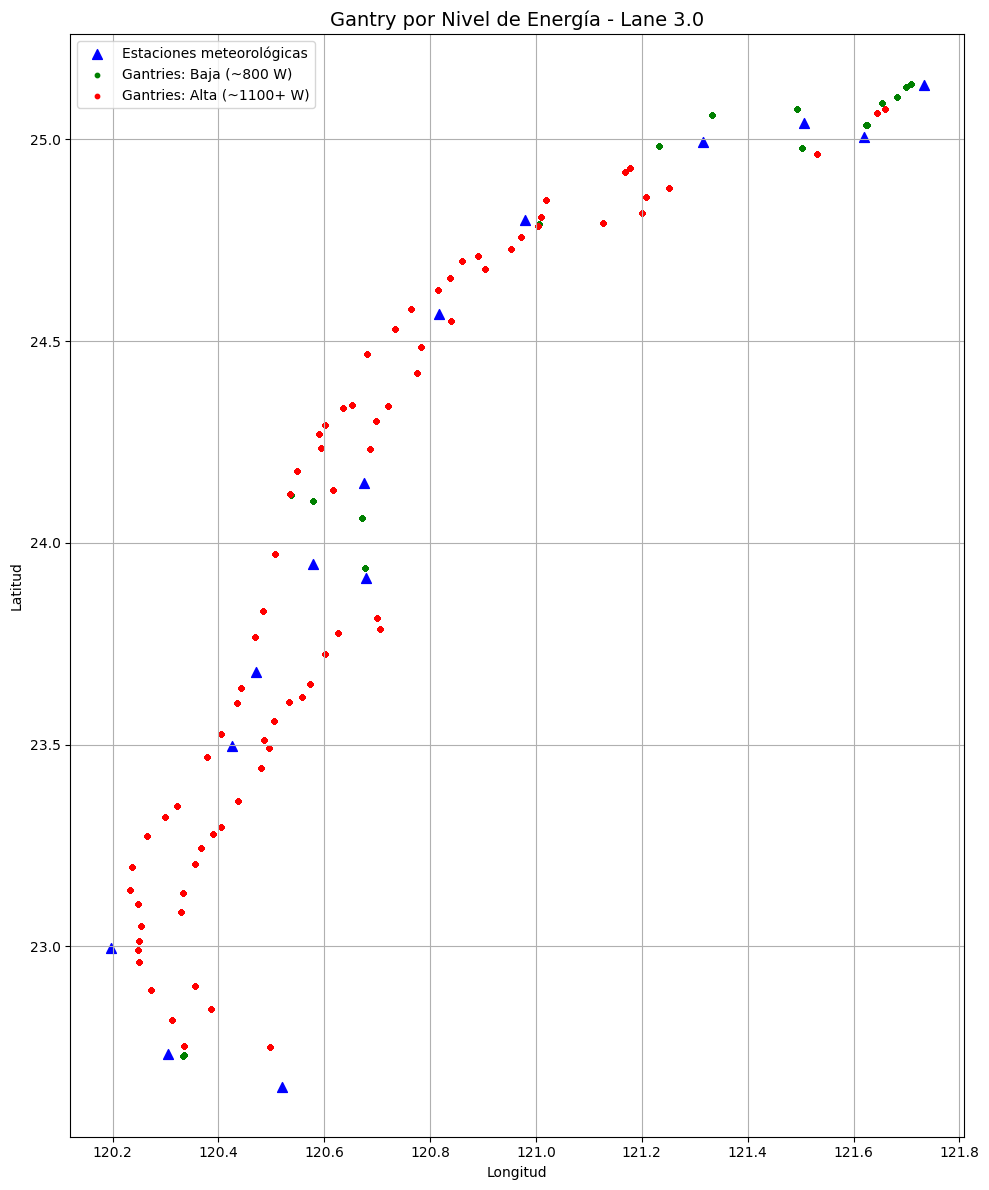

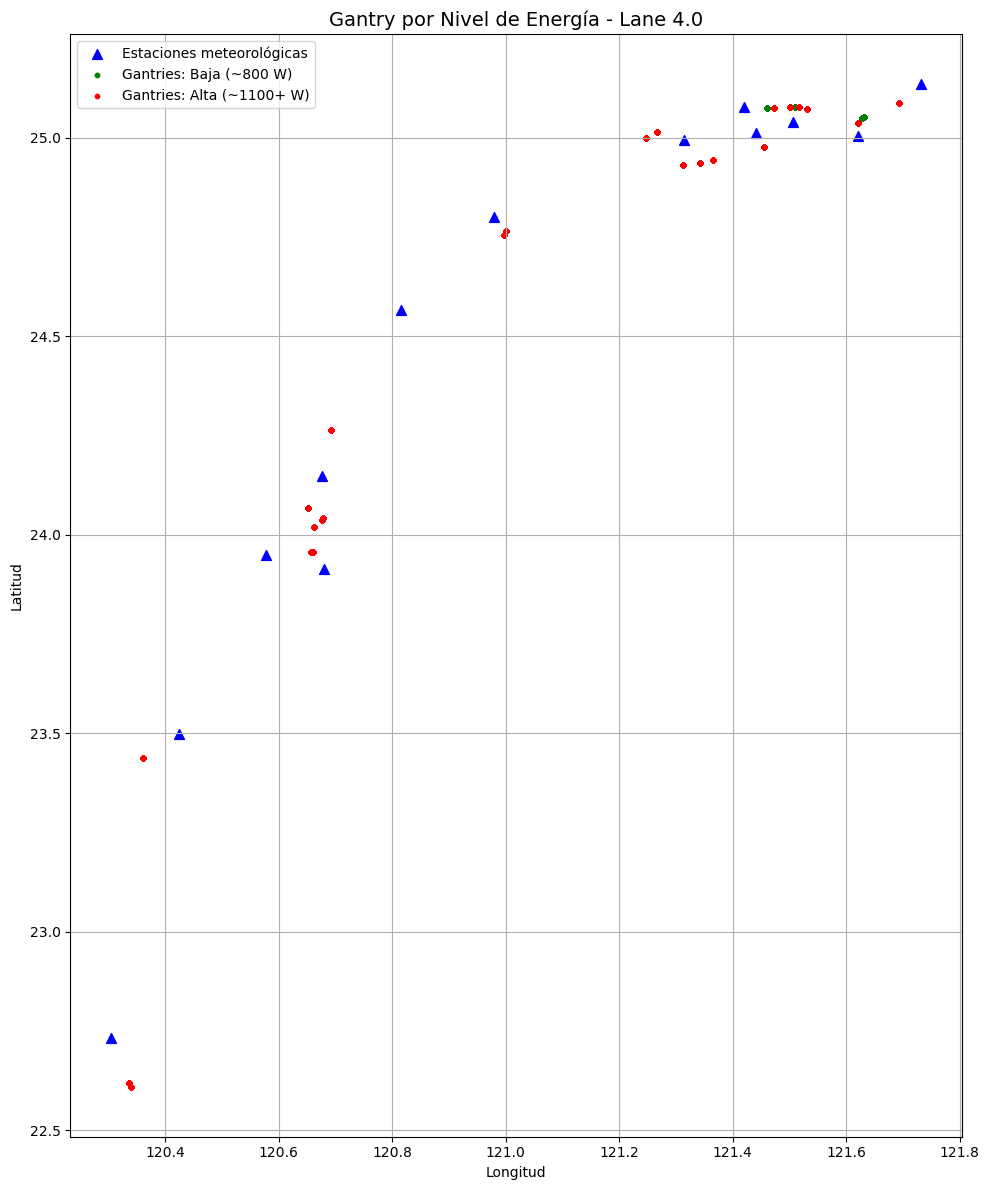

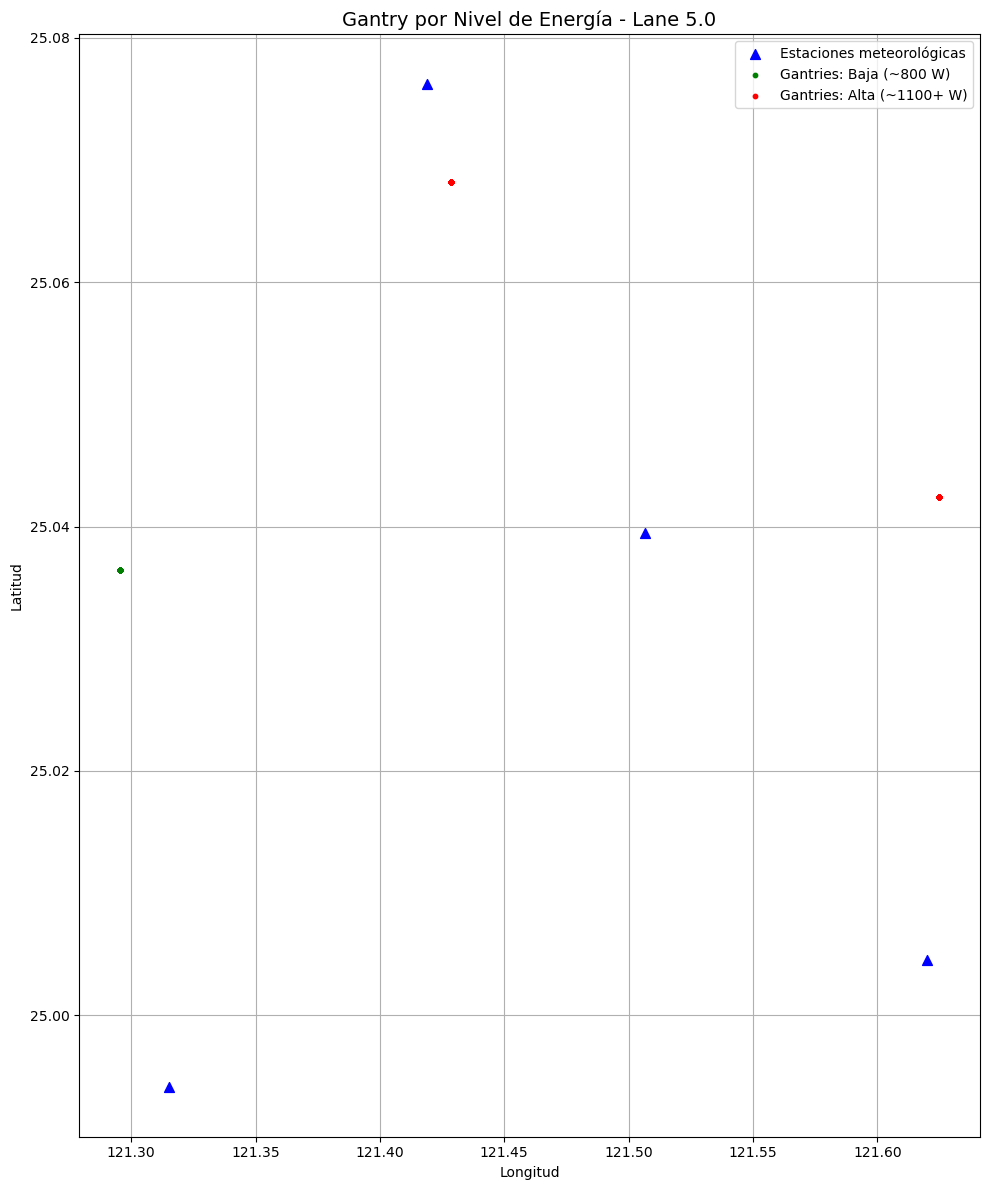

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar y preparar dataset ===
df = pd.read_csv("training_ready_dataset_balltree.csv")

# === 2. Filtrar columnas necesarias y eliminar nulos ===
df = df.dropna(subset=[
    'temperature', 'lane count', 'total_energy_watts',
    'latitude', 'longitude', 'station_latitude', 'station_longitude'
])

# === 3. Eliminar outliers en energía (IQR) ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 4. Clasificar por grupo energético ===
df['energy_group'] = df['total_energy_watts'].apply(lambda x: 'Baja (~800)' if x < 950 else 'Alta (~1100+)')

# === 5. Obtener carriles únicos ===
lane_values = sorted(df['lane count'].unique())

# === 6. Generar un mapa por cada lane ===
for lane in lane_values:
    lane_df = df[df['lane count'] == lane]

    plt.figure(figsize=(10, 12))
    plt.title(f"Gantry por Nivel de Energía - Lane {lane}", fontsize=14)

    # Estaciones meteorológicas (azul)
    stations = lane_df[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
    plt.scatter(
        stations['station_longitude'], stations['station_latitude'],
        color='blue', label='Estaciones meteorológicas', s=50, marker='^'
    )

    # Gantries: baja energía
    plt.scatter(
        lane_df[lane_df['energy_group'] == 'Baja (~800)']['longitude'],
        lane_df[lane_df['energy_group'] == 'Baja (~800)']['latitude'],
        color='green', label='Gantries: Baja (~800 W)', s=10
    )

    # Gantries: alta energía
    plt.scatter(
        lane_df[lane_df['energy_group'] == 'Alta (~1100+)']['longitude'],
        lane_df[lane_df['energy_group'] == 'Alta (~1100+)']['latitude'],
        color='red', label='Gantries: Alta (~1100+ W)', s=10
    )

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\3407145938.py:5: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("training_ready_dataset_balltree.csv")


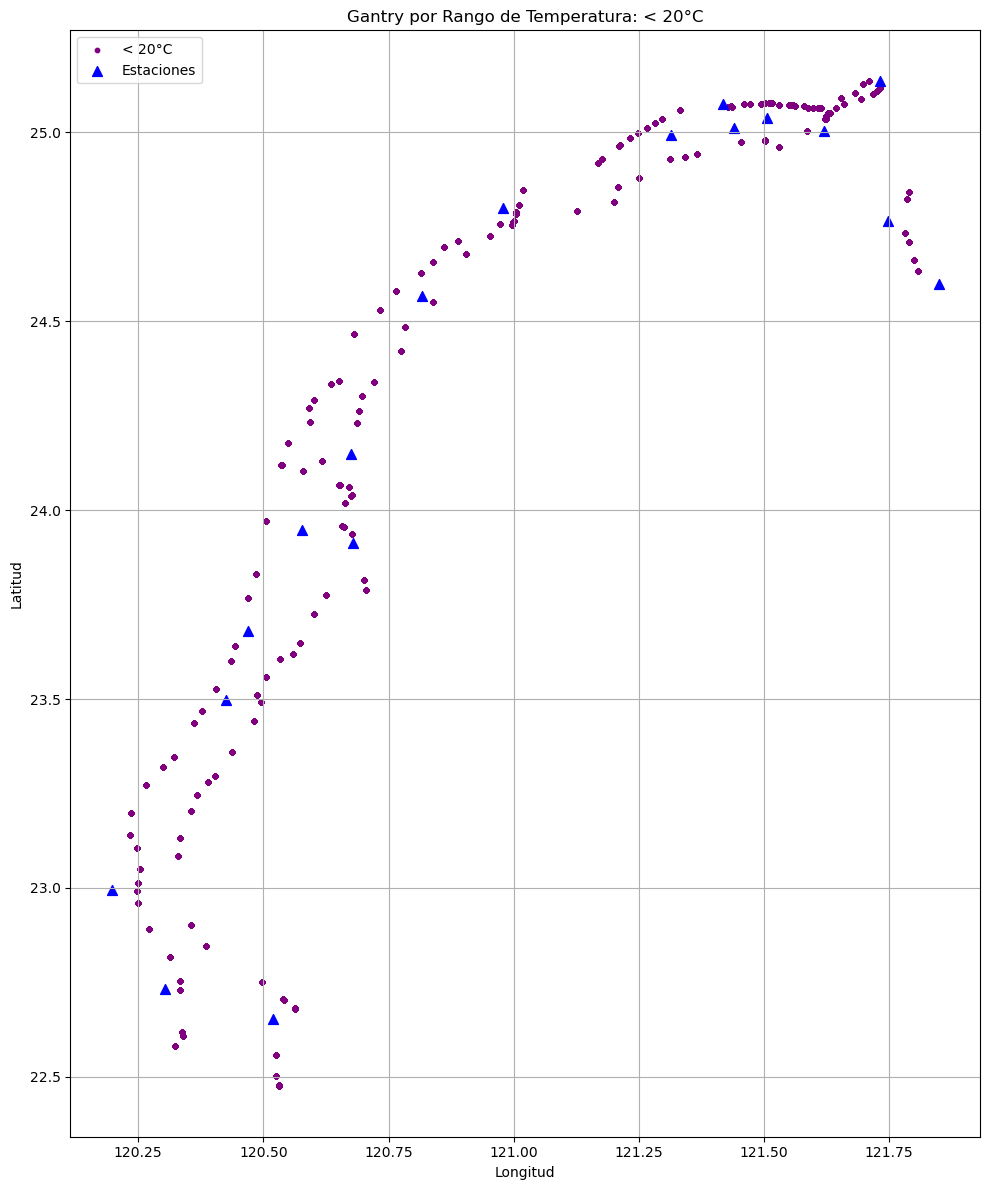

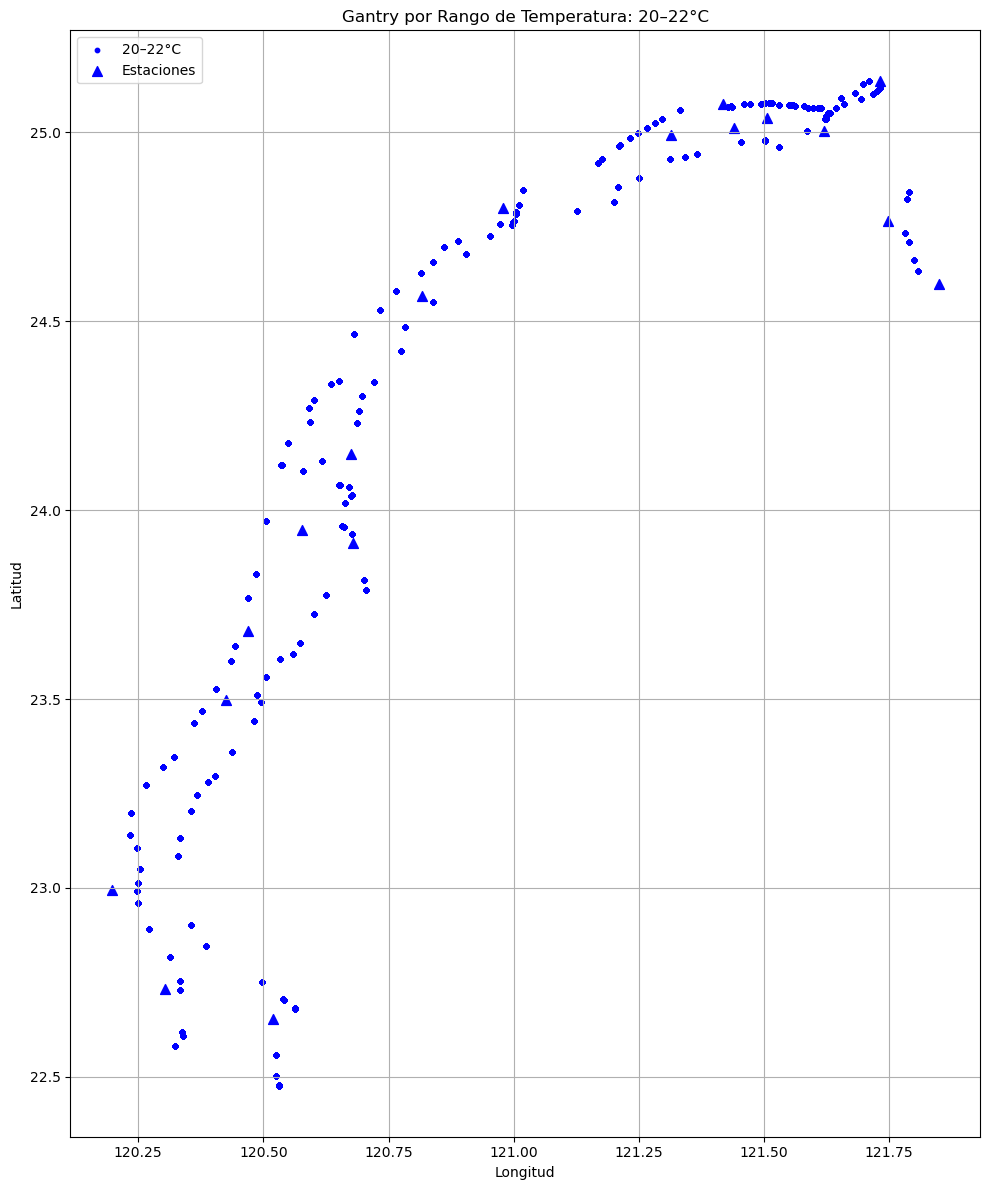

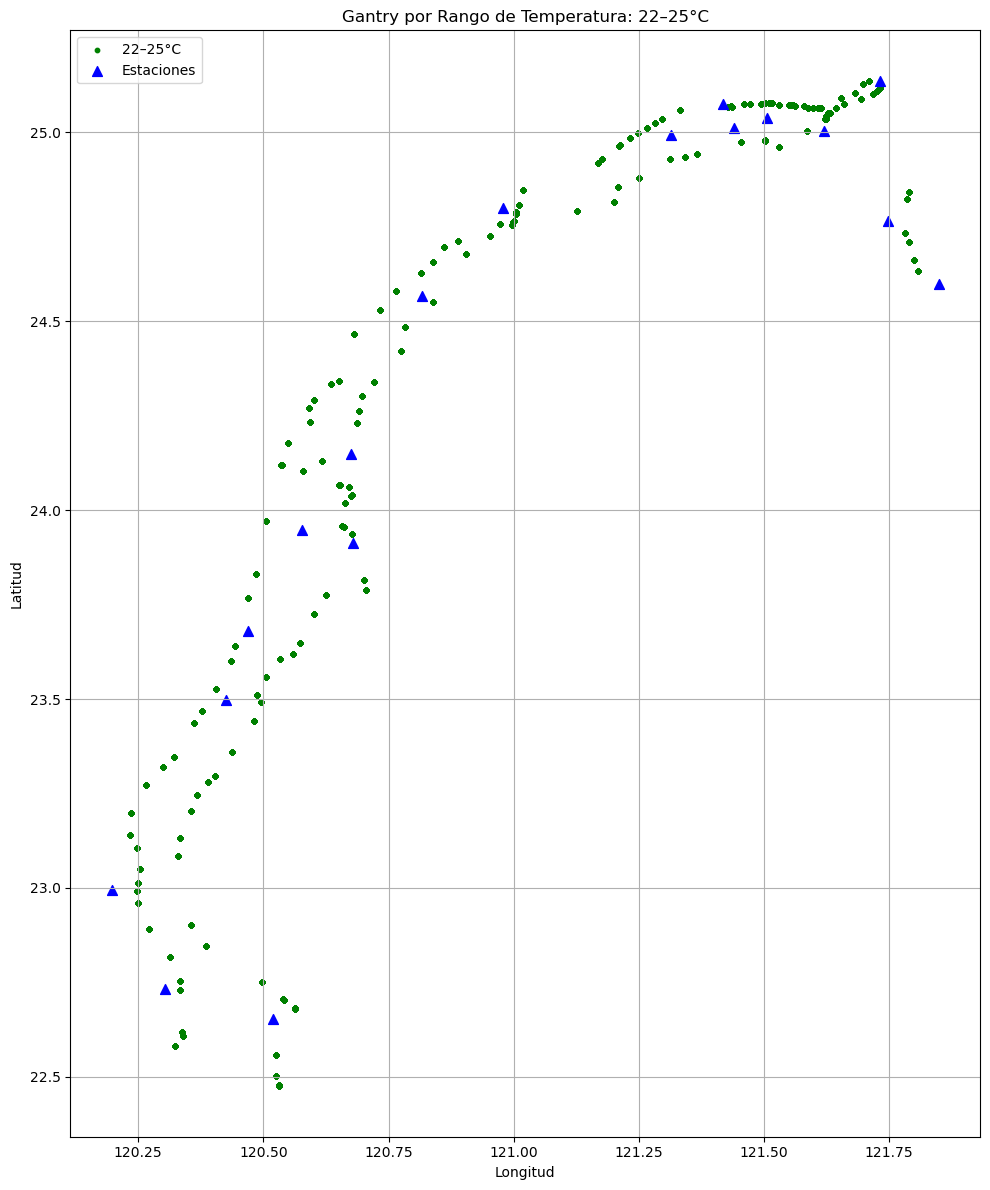

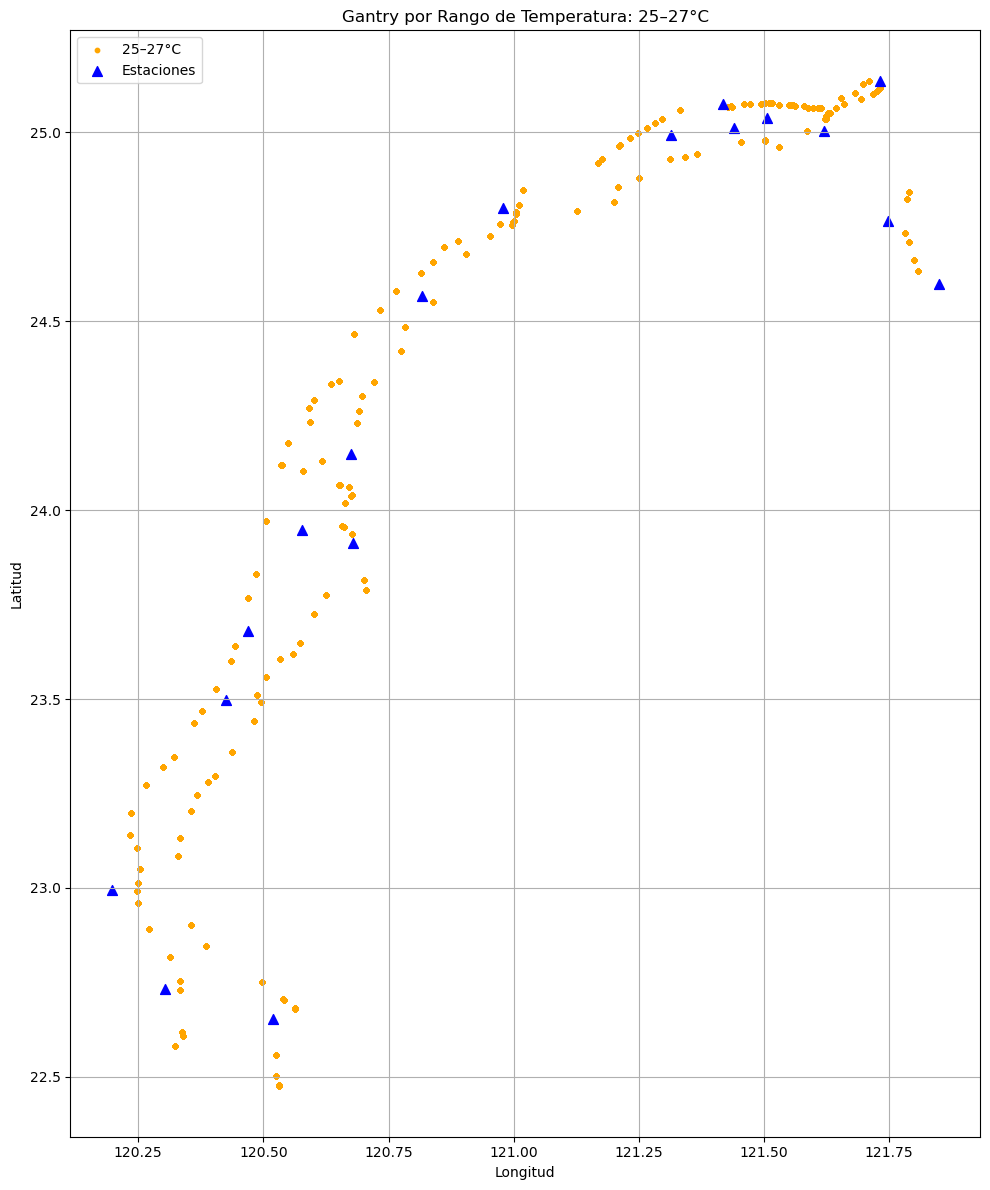

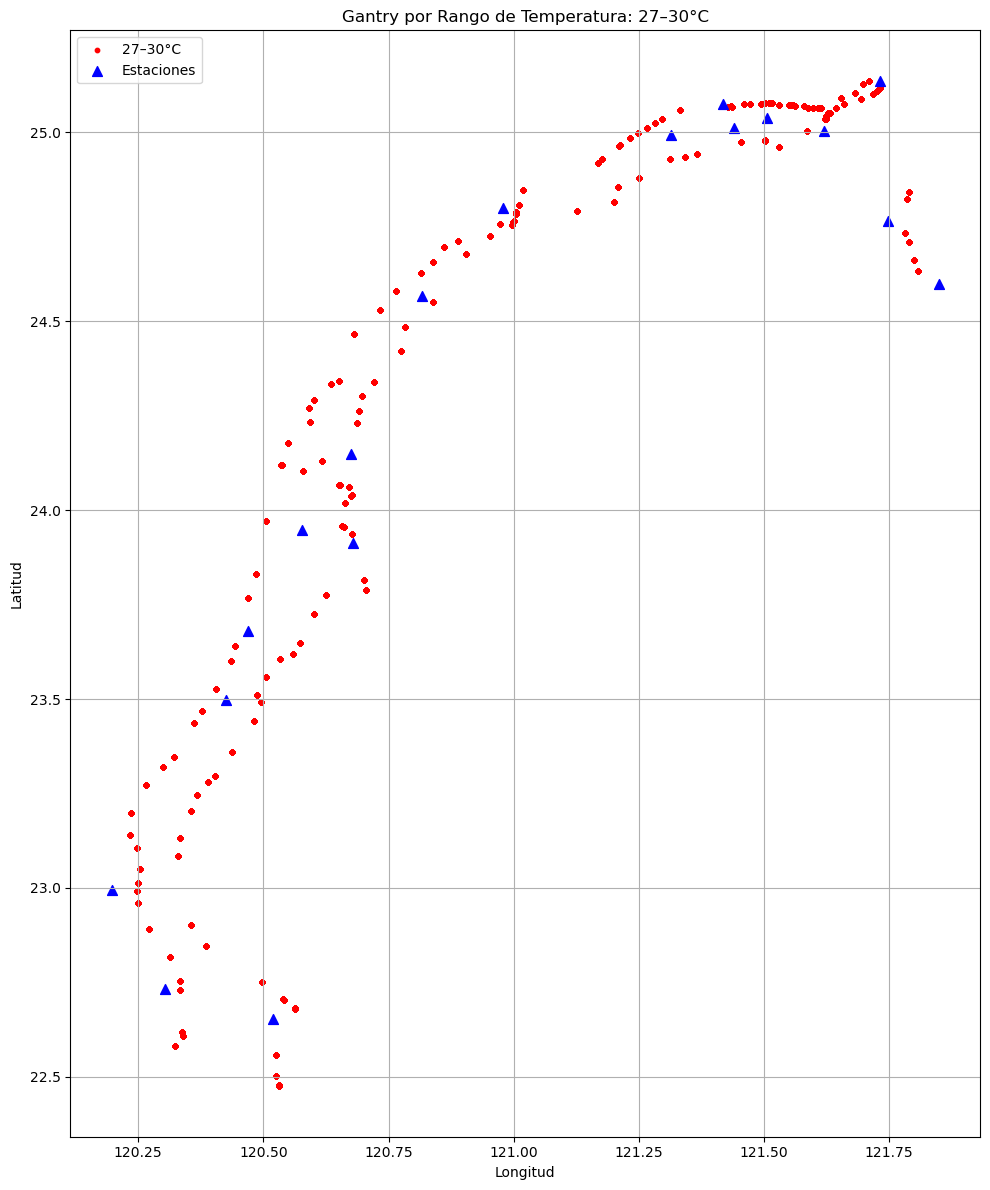

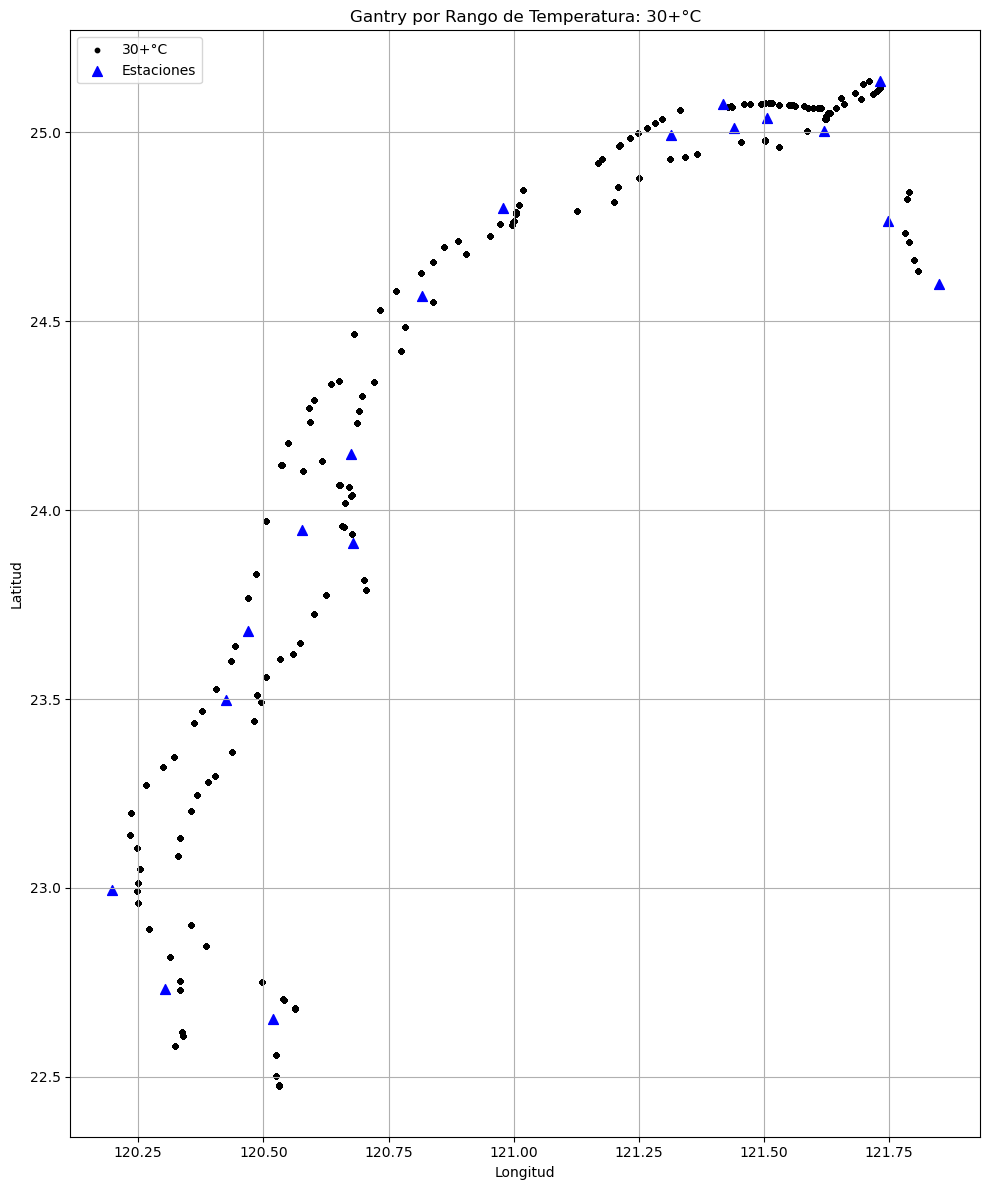

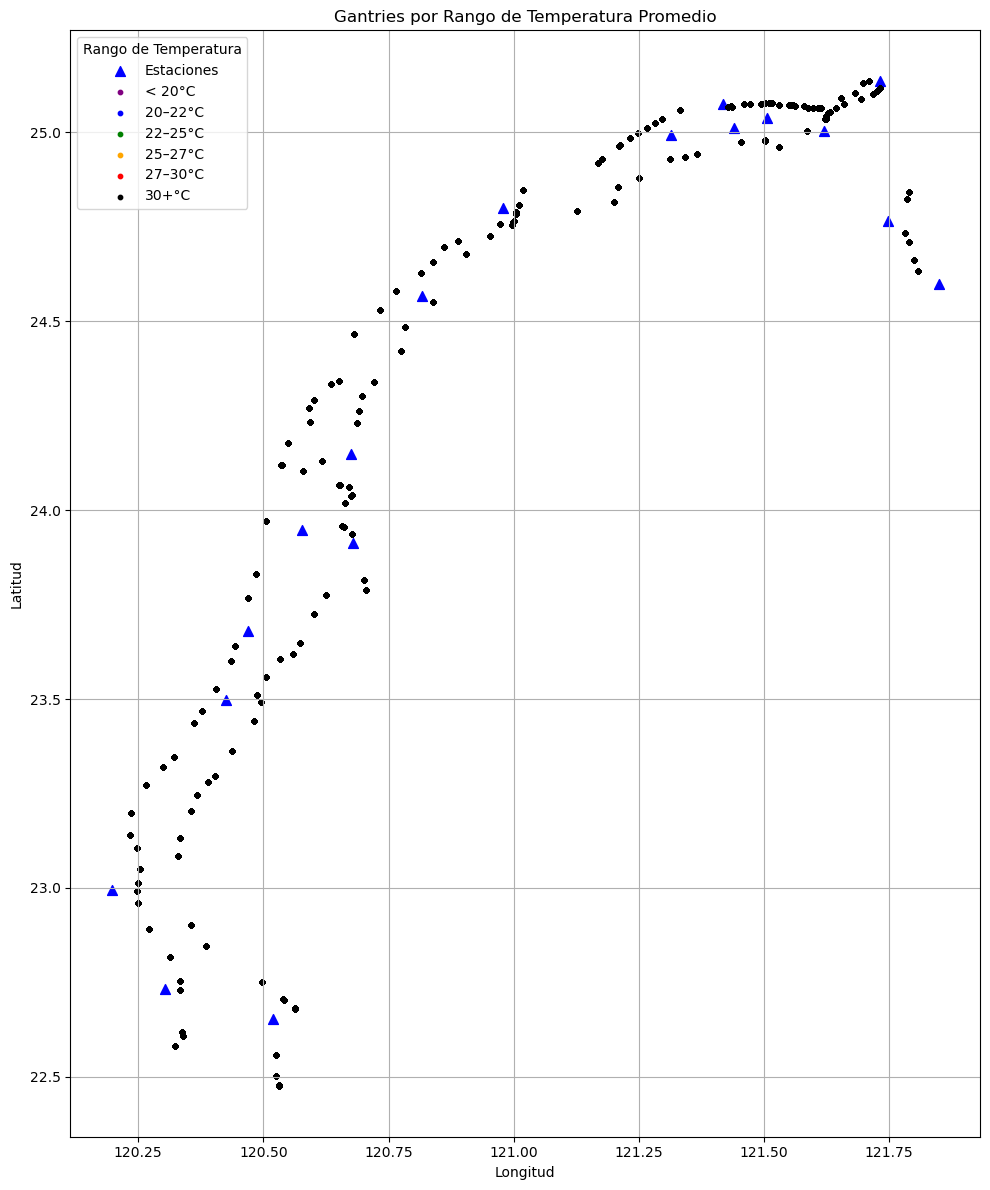

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# === Cargar datos ===
df = pd.read_csv("training_ready_dataset_balltree.csv")
df = df.dropna(subset=[
    'temperature', 'latitude', 'longitude',
    'station_latitude', 'station_longitude', 'stationid'
])

# === Clasificar por rango de temperatura promedio ===
def categorize_temp(temp):
    if temp < 20:
        return "< 20°C"
    elif temp < 22:
        return "20–22°C"
    elif temp < 25:
        return "22–25°C"
    elif temp < 27:
        return "25–27°C"
    elif temp < 30:
        return "27–30°C"
    else:
        return "30+°C"

df['temp_range'] = df['temperature'].apply(categorize_temp)

# === Colores por rango ===
color_map = {
    "< 20°C": "purple",
    "20–22°C": "blue",
    "22–25°C": "green",
    "25–27°C": "orange",
    "27–30°C": "red",
    "30+°C": "black"
}
temp_ranges = list(color_map.keys())

# === Gráfico por cada rango ===
for temp_range in temp_ranges:
    temp_df = df[df['temp_range'] == temp_range]
    plt.figure(figsize=(10, 12))
    plt.title(f"Gantry por Rango de Temperatura: {temp_range}")
    plt.scatter(temp_df['longitude'], temp_df['latitude'], color=color_map[temp_range], label=temp_range, s=10)
    stations = df[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
    plt.scatter(stations['station_longitude'], stations['station_latitude'], color='blue', label='Estaciones', s=50, marker='^')
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Mapa combinado ===
plt.figure(figsize=(10, 12))
plt.title("Gantries por Rango de Temperatura Promedio")

# Estaciones
stations = df[['stationid', 'station_latitude', 'station_longitude']].drop_duplicates()
plt.scatter(stations['station_longitude'], stations['station_latitude'], color='blue', label='Estaciones', s=50, marker='^')

# Gantries por rango
for temp_range in temp_ranges:
    temp_df = df[df['temp_range'] == temp_range]
    plt.scatter(temp_df['longitude'], temp_df['latitude'], color=color_map[temp_range], label=temp_range, s=10)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(title='Rango de Temperatura')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 1. Cargar y limpiar dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df.dropna(subset=['temperature', 'lane count', 'total_energy_watts', 'date', 'stationid'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['is_summer'] = df['date'].dt.month.isin([6, 7, 8]).astype(int)

# Eliminar outliers en energía (IQR)
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 2. Selección de variables ===
X = df[['temperature', 'lane count', 'is_summer', 'stationid']]
y = df['total_energy_watts']

# === 3. División de datos ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 4. Entrenamiento con CatBoost ===
cat_features = ['stationid']
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train, cat_features=cat_features)

# === 5. Evaluación del modelo ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("🔍 Evaluación del Modelo:")
print(f" - R²: {r2:.4f}")
print(f" - RMSE: {rmse:.2f} watts")
print(f" - MAE: {mae:.2f} watts")

# === 6. Función de predicción personalizada ===
def predict_energy_for_range(temp_min, temp_max, lane_count, is_summer, stationid):
    temp_range = np.linspace(temp_min, temp_max, num=50)
    input_data = pd.DataFrame({
        'temperature': temp_range,
        'lane count': [lane_count] * len(temp_range),
        'is_summer': [int(is_summer)] * len(temp_range),
        'stationid': [stationid] * len(temp_range)
    })
    predictions = model.predict(input_data)
    return predictions.mean()

# === 7. Ejemplo de uso ===
avg_energy = predict_energy_for_range(20, 25, lane_count=3, is_summer=True, stationid='C0AC40')
print(f"\n⚡ Energía promedio predicha (20–25°C, 3 carriles, verano, estación C0AC40): {avg_energy:.2f} watts")


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\3490598265.py:8: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


🔍 Evaluación del Modelo:
 - R²: 0.5748
 - RMSE: 140.35 watts
 - MAE: 100.03 watts

⚡ Energía promedio predicha (20–25°C, 3 carriles, verano, estación C0AC40): 1130.38 watts


In [38]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt

# === 1. Load and clean dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df.dropna(subset=['temperature', 'lane count', 'total_energy_watts', 'date', 'stationid'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop 2025 data
df = df[df['date'].dt.year != 2025]

# Create is_summer feature
df['is_summer'] = df['date'].dt.month.isin([6, 7, 8]).astype(int)

# === 2. Remove outliers from total_energy_watts ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Feature Engineering ===
df['temp_x_lane'] = df['temperature'] * df['lane count']
df['temp_squared'] = df['temperature'] ** 2

# === 4. Features and Target ===
X = df[['temperature', 'lane count', 'is_summer', 'stationid', 'temp_x_lane', 'temp_squared']]
y = df['total_energy_watts']

# === 5. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 6. Train CatBoost ===
cat_features = ['stationid']
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)
model.fit(X_train, y_train, cat_features=cat_features)

# === 7. Evaluate ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("🔍 Evaluación del Modelo:")
print(f" - R²: {r2:.4f}")
print(f" - RMSE: {rmse:.2f} watts")
print(f" - MAE: {mae:.2f} watts")

# === 8. Manual Cross-Validation (5-Fold) ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []

for train_idx, val_idx in cv.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model_cv = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        random_state=42,
        verbose=0
    )
    model_cv.fit(X_train_cv, y_train_cv, cat_features=['stationid'])
    y_pred_cv = model_cv.predict(X_val_cv)
    r2_cv = r2_score(y_val_cv, y_pred_cv)
    r2_scores.append(r2_cv)

print(f"\n✅ R² promedio en Cross-Validation (5-Fold): {np.mean(r2_scores):.4f}")

# === 9. SHAP Analysis ===
print("\n📊 Generando gráfico SHAP...")
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()

# === 10. Prediction Function ===
def predict_energy_for_range(temp_min, temp_max, lane_count, is_summer, stationid):
    temp_range = np.linspace(temp_min, temp_max, num=50)
    input_data = pd.DataFrame({
        'temperature': temp_range,
        'lane count': [lane_count] * len(temp_range),
        'is_summer': [int(is_summer)] * len(temp_range),
        'stationid': [stationid] * len(temp_range)
    })
    input_data['temp_x_lane'] = input_data['temperature'] * input_data['lane count']
    input_data['temp_squared'] = input_data['temperature'] ** 2
    predictions = model.predict(input_data)
    return predictions.mean()

# === 11. Example usage ===
avg_energy = predict_energy_for_range(20, 25, lane_count=3, is_summer=True, stationid='C0AC40')
print(f"\n⚡ Energía promedio predicha (20–25°C, 3 carriles, verano, estación C0AC40): {avg_energy:.2f} watts")


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\1273460691.py:10: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


🔍 Evaluación del Modelo:
 - R²: 0.5753
 - RMSE: 140.26 watts
 - MAE: 100.09 watts


KeyboardInterrupt: 

C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\126253483.py:10: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


🔍 Evaluación del Modelo:
 - R²: 0.9094
 - RMSE: 64.63 watts
 - MAE: 28.05 watts

📈 Cross-Validation Progress:
🔄 Fold 1/5...
   ✅ R²: 0.9095 | RMSE: 64.59 | MAE: 28.02
🔄 Fold 2/5...
   ✅ R²: 0.9081 | RMSE: 64.95 | MAE: 28.14
🔄 Fold 3/5...
   ✅ R²: 0.9063 | RMSE: 65.71 | MAE: 28.39
🔄 Fold 4/5...
   ✅ R²: 0.9124 | RMSE: 63.68 | MAE: 28.28
🔄 Fold 5/5...
   ✅ R²: 0.9079 | RMSE: 65.52 | MAE: 28.38

📊 Cross-Validation Summary (5 Folds):
   R² promedio: 0.9088
   RMSE promedio: 64.89 watts
   MAE promedio: 28.24 watts

📊 Generando gráfico SHAP...


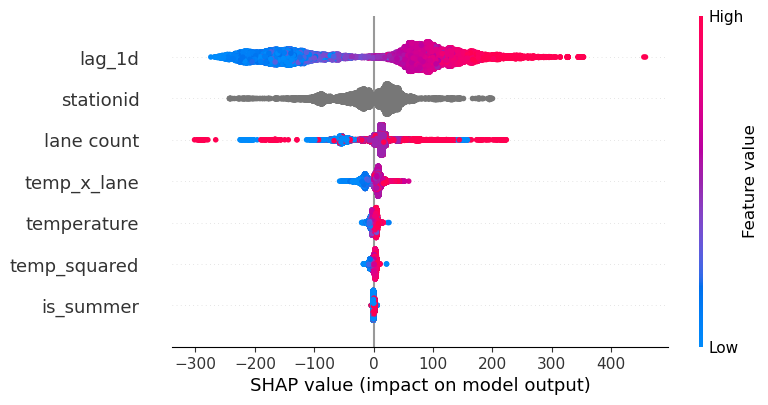


⚡ Energía promedio predicha (20–25°C, 3 carriles, verano, estación C0AC40, lag=1100): 1127.48 watts


In [39]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df.dropna(subset=['temperature', 'lane count', 'total_energy_watts', 'date', 'stationid'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].dt.year != 2025]  # Eliminar datos del 2025
df['is_summer'] = df['date'].dt.month.isin([6, 7, 8]).astype(int)

# === 2. Eliminar outliers en energía ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Características adicionales ===
df['temp_x_lane'] = df['temperature'] * df['lane count']
df['temp_squared'] = df['temperature'] ** 2

# === 4. Crear lag de 1 día (por estación) ===
df = df.sort_values(by=['stationid', 'date'])
df['lag_1d'] = df.groupby('stationid')['total_energy_watts'].shift(1)
df = df.dropna(subset=['lag_1d'])

# === 5. Variables independientes y objetivo ===
X = df[['temperature', 'lane count', 'is_summer', 'stationid', 'temp_x_lane', 'temp_squared', 'lag_1d']]
y = df['total_energy_watts']

# === 6. División entrenamiento/prueba ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 7. Entrenamiento del modelo ===
cat_features = ['stationid']
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)
model.fit(X_train, y_train, cat_features=cat_features)

# === 8. Evaluación en conjunto de prueba ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("🔍 Evaluación del Modelo:")
print(f" - R²: {r2:.4f}")
print(f" - RMSE: {rmse:.2f} watts")
print(f" - MAE: {mae:.2f} watts")

# === 9. Validación cruzada con progreso ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
rmse_scores = []
mae_scores = []

print("\n📈 Cross-Validation Progress:")

for fold, (train_idx, val_idx) in enumerate(cv.split(X), 1):
    print(f"🔄 Fold {fold}/5...")

    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model_cv = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        random_state=42,
        verbose=0
    )
    model_cv.fit(X_train_cv, y_train_cv, cat_features=['stationid'])

    y_pred_cv = model_cv.predict(X_val_cv)

    r2_cv = r2_score(y_val_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    mae_cv = mean_absolute_error(y_val_cv, y_pred_cv)

    print(f"   ✅ R²: {r2_cv:.4f} | RMSE: {rmse_cv:.2f} | MAE: {mae_cv:.2f}")

    r2_scores.append(r2_cv)
    rmse_scores.append(rmse_cv)
    mae_scores.append(mae_cv)

# === 10. Resumen de Cross-Validation ===
print("\n📊 Cross-Validation Summary (5 Folds):")
print(f"   R² promedio: {np.mean(r2_scores):.4f}")
print(f"   RMSE promedio: {np.mean(rmse_scores):.2f} watts")
print(f"   MAE promedio: {np.mean(mae_scores):.2f} watts")

# === 11. SHAP Analysis ===
print("\n📊 Generando gráfico SHAP...")
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()

# === 12. Función de predicción personalizada ===
def predict_energy_for_range(temp_min, temp_max, lane_count, is_summer, stationid, lag_1d_value):
    temp_range = np.linspace(temp_min, temp_max, num=50)
    input_data = pd.DataFrame({
        'temperature': temp_range,
        'lane count': [lane_count] * len(temp_range),
        'is_summer': [int(is_summer)] * len(temp_range),
        'stationid': [stationid] * len(temp_range),
        'lag_1d': [lag_1d_value] * len(temp_range)
    })
    input_data['temp_x_lane'] = input_data['temperature'] * input_data['lane count']
    input_data['temp_squared'] = input_data['temperature'] ** 2
    predictions = model.predict(input_data)
    return predictions.mean()

# === 13. Ejemplo de uso ===
avg_energy = predict_energy_for_range(
    temp_min=20, temp_max=25,
    lane_count=3,
    is_summer=True,
    stationid='C0AC40',
    lag_1d_value=1100  # Valor típico anterior del mismo gantry
)
print(f"\n⚡ Energía promedio predicha (20–25°C, 3 carriles, verano, estación C0AC40, lag=1100): {avg_energy:.2f} watts")


C:\Users\gusta\AppData\Local\Temp\ipykernel_19600\2465991821.py:10: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("TrainingDataSet.csv")


🔍 Evaluación del Modelo:
 - R²: 0.9094
 - RMSE: 64.63 watts
 - MAE: 28.05 watts

📈 Cross-Validation Progress:
🔄 Fold 1/5...
   ✅ R²: 0.9095 | RMSE: 64.59 | MAE: 28.02
🔄 Fold 2/5...
   ✅ R²: 0.9081 | RMSE: 64.95 | MAE: 28.14
🔄 Fold 3/5...
   ✅ R²: 0.9063 | RMSE: 65.71 | MAE: 28.39
🔄 Fold 4/5...
   ✅ R²: 0.9124 | RMSE: 63.68 | MAE: 28.28
🔄 Fold 5/5...
   ✅ R²: 0.9079 | RMSE: 65.52 | MAE: 28.38

📊 Cross-Validation Summary (5 Folds):
   R² promedio: 0.9088
   RMSE promedio: 64.89 watts
   MAE promedio: 28.24 watts

📊 Generando gráfico SHAP...


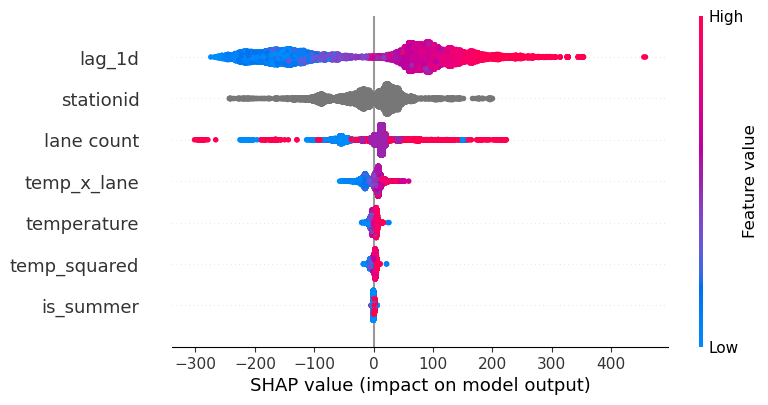


⚡ Predicción promedio (20–25°C, 3 carriles, verano, estación C0AC40): 1127.48 watts

📅 Evaluación mensual del modelo:
 - R² mensual: 0.9998
 - RMSE mensual: 7334.66 watts
 - MAE mensual: 5573.06 watts


In [40]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt

# === 1. Cargar y limpiar dataset ===
df = pd.read_csv("TrainingDataSet.csv")
df = df.dropna(subset=['temperature', 'lane count', 'total_energy_watts', 'date', 'stationid'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].dt.year != 2025]
df['is_summer'] = df['date'].dt.month.isin([6, 7, 8]).astype(int)

# === 2. Eliminar outliers en energía ===
Q1 = df['total_energy_watts'].quantile(0.25)
Q3 = df['total_energy_watts'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['total_energy_watts'] >= lower) & (df['total_energy_watts'] <= upper)]

# === 3. Características adicionales ===
df['temp_x_lane'] = df['temperature'] * df['lane count']
df['temp_squared'] = df['temperature'] ** 2

# === 4. Crear lag de 1 día (por estación) ===
df = df.sort_values(by=['stationid', 'date'])
df['lag_1d'] = df.groupby('stationid')['total_energy_watts'].shift(1)
df = df.dropna(subset=['lag_1d'])

# === 5. Variables independientes y objetivo ===
X = df[['temperature', 'lane count', 'is_summer', 'stationid', 'temp_x_lane', 'temp_squared', 'lag_1d']]
y = df['total_energy_watts']

# === 6. División entrenamiento/prueba ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 7. Entrenamiento del modelo ===
cat_features = ['stationid']
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)
model.fit(X_train, y_train, cat_features=cat_features)

# === 8. Evaluación diaria ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("🔍 Evaluación del Modelo:")
print(f" - R²: {r2:.4f}")
print(f" - RMSE: {rmse:.2f} watts")
print(f" - MAE: {mae:.2f} watts")

# === 9. Validación cruzada ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
rmse_scores = []
mae_scores = []

print("\n📈 Cross-Validation Progress:")
for fold, (train_idx, val_idx) in enumerate(cv.split(X), 1):
    print(f"🔄 Fold {fold}/5...")

    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    model_cv = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        random_state=42,
        verbose=0
    )
    model_cv.fit(X_train_cv, y_train_cv, cat_features=['stationid'])

    y_pred_cv = model_cv.predict(X_val_cv)

    r2_cv = r2_score(y_val_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    mae_cv = mean_absolute_error(y_val_cv, y_pred_cv)

    print(f"   ✅ R²: {r2_cv:.4f} | RMSE: {rmse_cv:.2f} | MAE: {mae_cv:.2f}")
    r2_scores.append(r2_cv)
    rmse_scores.append(rmse_cv)
    mae_scores.append(mae_cv)

print("\n📊 Cross-Validation Summary (5 Folds):")
print(f"   R² promedio: {np.mean(r2_scores):.4f}")
print(f"   RMSE promedio: {np.mean(rmse_scores):.2f} watts")
print(f"   MAE promedio: {np.mean(mae_scores):.2f} watts")

# === 10. SHAP Analysis ===
print("\n📊 Generando gráfico SHAP...")
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=10)
plt.show()

# === 11. Función de predicción personalizada ===
def predict_energy_for_range(temp_min, temp_max, lane_count, is_summer, stationid, lag_1d_value):
    temp_range = np.linspace(temp_min, temp_max, num=50)
    input_data = pd.DataFrame({
        'temperature': temp_range,
        'lane count': [lane_count] * len(temp_range),
        'is_summer': [int(is_summer)] * len(temp_range),
        'stationid': [stationid] * len(temp_range),
        'lag_1d': [lag_1d_value] * len(temp_range)
    })
    input_data['temp_x_lane'] = input_data['temperature'] * input_data['lane count']
    input_data['temp_squared'] = input_data['temperature'] ** 2
    predictions = model.predict(input_data)
    return predictions.mean()

# === 12. Ejemplo de uso ===
avg_energy = predict_energy_for_range(20, 25, 3, True, 'C0AC40', 1100)
print(f"\n⚡ Predicción promedio (20–25°C, 3 carriles, verano, estación C0AC40): {avg_energy:.2f} watts")

# === 13. Evaluación mensual del modelo ===
df_model_input = X.copy()
df_model_input['date'] = df.loc[X.index, 'date'].values
df_model_input['real_energy'] = y
df_model_input['predicted_energy'] = model.predict(X)

df_model_input['month'] = df_model_input['date'].dt.to_period('M')
monthly_real = df_model_input.groupby('month')['real_energy'].sum()
monthly_pred = df_model_input.groupby('month')['predicted_energy'].sum()

r2_month = r2_score(monthly_real, monthly_pred)
rmse_month = np.sqrt(mean_squared_error(monthly_real, monthly_pred))
mae_month = mean_absolute_error(monthly_real, monthly_pred)

print("\n📅 Evaluación mensual del modelo:")
print(f" - R² mensual: {r2_month:.4f}")
print(f" - RMSE mensual: {rmse_month:.2f} watts")
print(f" - MAE mensual: {mae_month:.2f} watts")


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF

# === 1. Cargar datos ===
df = pd.read_csv("tu_archivo.csv", parse_dates=["fecha"])

# Asegura columnas necesarias
assert {'fecha', 'temperature', 'lane count', 'real_energy', 'predicted_energy'}.issubset(df.columns)

# === 2. Crear columna 'mes' ===
df['mes'] = df['fecha'].dt.to_period('M').astype(str)

# === 3. Agrupar por mes, temperatura y lane count ===
monthly = df.groupby(['mes', 'temperature', 'lane count']).agg({
    'real_energy': 'mean',
    'predicted_energy': 'mean'
}).reset_index()

# === 4. Crear gráfico comparativo ===
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly, x='mes', y='real_energy', label='Consumo Real', marker='o')
sns.lineplot(data=monthly, x='mes', y='predicted_energy', label='Consumo Predicho', marker='o')
plt.title("Consumo mensual real vs predicho")
plt.xlabel("Mes")
plt.ylabel("Energía (watts)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("grafico_consumo.png")
plt.close()

# === 5. Crear PDF con gráfico y tabla resumen ===
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "📊 Consumo mensual real vs predicho", ln=True)

# Insertar gráfico
pdf.image("grafico_consumo.png", x=10, y=25, w=190)

# Espacio
pdf.ln(110)

# Insertar tabla (primeros 10 valores)
pdf.set_font("Arial", size=10)
pdf.cell(0, 10, "Resumen (primeros 10 registros):", ln=True)
pdf.set_font("Arial", size=8)

for i, row in monthly.head(10).iterrows():
    pdf.cell(0, 6, f"Mes: {row['mes']}, Temp: {row['temperature']}°C, Carriles: {row['lane count']}, "
                   f"Real: {row['real_energy']:.2f}W, Predicho: {row['predicted_energy']:.2f}W", ln=True)

# === 6. Guardar PDF ===
pdf.output("Consumo_Mensual_Comparativo.pdf")
print("✅ PDF generado: Consumo_Mensual_Comparativo.pdf")


FileNotFoundError: [Errno 2] No such file or directory: 'tu_archivo.csv'